# Part 1: **NLP & Music Lyrics** (Assignment 1)

I have always been captivated by **music's ability to profoundly influence emotions**. As supporting evidence, I listened to more than $40,000$ minutes of music in $2023$ (which is $28$ days nonstop!).

My personal love for **indie folk music** due to its soothing melodies and reflective lyrics sparked my curiosity to explore the emotions embedded within lyrics across different genres.

In this project, **I aim to conduct a sentiment analysis** of the lyrics from my favorite indie folk songs and compare that to some my favorite rock music. My goal is to uncover nuances of emotional expression across these two genres and understand how that impacts the listener experience. The central question I want to explore is: **are the lyrics, and therefore the sentiments elicited, very different between rock and indie folk?**

I have curated a dataset of lyrics across a range of indie folk and rock artists, sourced from Genius API. By delving into the sentiment of these lyrics through lexical analysis, I aim to offer insights into how these two genres articulate emotions differently and if we can create a machine learning model that can predict a genre based on its lyrics.

In [1]:
%%capture
!pip install lyricsgenius
!pip install --upgrade pip

!pip install wordcloud

from lyricsgenius import Genius
import requests
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

I opted to collect my song lyrics dataset through queries to the **Genius API**. This allowed me to retrieve a diverse range of musical content to drive my textual analysis. I chose Genius specifically because of its vast catalog spanning many artists and genres as it takes pride in being *the world's greatest public knowledge project since Wikipedia*.

I searched for each target artist's most popular tracks in order to focus on their most popular lyrical works. Analyzing these popular songs enhances the relevance of my research into understanding emotional sentiment underneath the music. I limited the scope of this project to the top $12$ songs per artist after trial and error as I aimed to balance sufficient volume with variety of music. In initial testing, the model had lower accuracy with fewer songs than $12$, likely due to insufficient data. On the other hand, including the full catalog also led to lower accuracy possibly due to overfitting effects.

In the database, I extracted only the song titles because other metadata such as the name of the album and release year to contextualize the lyric writing process across timelines was not available with Genius. Understanding when the various songs were written could provide insight into how sentiment has evolved over an artist’s musical journey, however this data was not possible with this API.

Additionally, I structured the dataset as a shareable CSV file to enable future collaboration or easy access to the data for analysis. Overall, my priority was balancing between efficiency (such that collecting the data did not take too long) and diversity (ensuring that there was enough data to allow for meaningful analysis).

In [2]:
'''
# My Genius API key
GENIUS_API_KEY = 'LPjIhEbQAgQDU6U2SHQCW2SwP5TpSJD4DzREuHi92Y-7woTUaO6MI8WMgO-ZE_Uo'
genius = Genius(GENIUS_API_KEY, timeout=1000)

# Listing of my favorite artists
my_artists = ['Gregory Alan Isakov', 'Birdtalker', 'Iron & Wine', 'Bon Iver',
                  'AC/DC', 'Red Hot Chilli Peppers', 'Queen', 'The Beatles']

tracks = []
query_number = 0
time_start = time.time()

for artist_name in my_artists:
    query_number += 1
    print(f'\nQuery number: {query_number}')

    # Selecting 12 songs from each of the favorite artists, based on popularity.
    artist = genius.search_artist(artist_name, max_songs=12, sort='popularity', include_features=True)

    if artist:
        for song in artist.songs:
            # Using getattr to avoid AttributeError for missing attributes
            song_lyrics = getattr(song, 'lyrics', "Lyrics not found")

            tracks.append({'artist': artist_name,
                'title': song.title,
                'lyrics': song_lyrics})

    time_end = time.time() # keeping time here because the genius api's timeout would be set accordingly
    print(f'Query {query_number} finished in {round(time_end - time_start, 2)} seconds.')
'''

tracklist = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQqQ2r66sXQ7_Ey9s8zqWR8TUyZkX7eXsfx9wFy15Vfnyh91076LvOxrmyNmrJGGcLGaUfsPzz5KVud/pub?output=csv')
print(tracklist.head())

                artist              title  \
0  Gregory Alan Isakov  If I Go, I’m Goin   
1  Gregory Alan Isakov      Big Black Car   
2  Gregory Alan Isakov          Amsterdam   
3  Gregory Alan Isakov           San Luis   
4  Gregory Alan Isakov    The Stable Song   

                                              lyrics  
0  19 ContributorsIf I Go, I’m Goin Lyrics[Verse ...  
1  32 ContributorsBig Black Car Lyrics[Verse 1]\n...  
2  13 ContributorsAmsterdam LyricsAll inside our ...  
3  7 ContributorsSan Luis Lyrics[Verse 1]\nWeight...  
4  24 ContributorsThe Stable Song LyricsRemember ...  


## Data Cleaning

Before I can analyse the lyrics, I needed to clean the lyrics scraped from Genius. Genius' scraped data included messy metadata which got in the way of analysing the lyrics. This is why my goal with data cleaning was to **isolate just the lyrics** to try and get the most accurate results.

The raw Genius data had extra information like contributor names and website annotations (eg.  in with the actual song words. It also included formatting from the web page, like HTML tags and carriage returns i.e. the formatting characters that force line breaks. So, I had to clean all of this to recover the lyrics alone.

Cleaning made sure there was no clutter interfering with counting words (during data analysis or understanding sentence sentiment). The code might get confused when trying to assess emotion in HTML tags or annotations.This is also why I standardized everything to lowercase as well so the computer treats words consistently and not affected by random capitalization, otherwise similar words such as "Jude" and "jude" might be treated differently.

Thus, I created a function that removed any irrelevant content in the lyrics strings. This enabled the lyrical analysis to just focus on the lyrics themselves without much distortion. The cleaned dataset sets a solid foundation for our next steps like modeling lyrical sentiment across the two genres for better results and higher accuracy in our model's results.

In [3]:
def clean_combined_lyrics(lyrics):

    """
    Clean up combined lyrics obtained from a Genius API.

    This function cleans up combined lyrics obtained from the API, removing extraneous information such as
    contributor info, annotations, HTML tags, and trailing "XEmbed" sections.

    Parameters:
    lyrics (str): The combined lyrics obtained from the API.

    Returns:
    str: The cleaned lyrics.

    Example:
    >>> before lyrics = "18 ContributorsIf I Go, I’m Goin Lyrics[Verse ..."
    >>> after cleaning = "This house, she's holdin' secrets Got my chang..."
    """

    # Step 1: Remove everything up to and including the word "Lyrics"
    # this is because the API outputs several things such as no. of contributors, translated languages, etc.

    lyrics = re.sub(r'^.*?Lyrics', '', lyrics, flags=re.IGNORECASE)

    # Step 2: Remove bracketed sections (annotations, contributor info)
    lyrics = re.sub(r'\[.*?\]', '', lyrics)

    # Step 3: Remove HTML tags if present
    lyrics = re.sub(r'<.*?>', '', lyrics)

    # Step 4: Remove newline and carriage return characters
    lyrics = lyrics.replace('\n', ' ').replace('\r', ' ')

    # Step 5: Remove the "XEmbed" which seems to be present at the end of each song where X is index number
    lyrics = re.sub(r'\w+Embed$', '', lyrics)

    # Step 6: Converting all text to lower case
    lyrics = lyrics.lower()

    # Final: Remove leading and trailing whitespace
    lyrics = lyrics.strip()

    return lyrics

# Applying the cleaning function to each lyric entry in the DataFrame into a new column called cleaned_lyrics
tracklist['cleaned_lyrics'] = tracklist['lyrics'].apply(clean_combined_lyrics)
tracklist

,artist,title,lyrics,cleaned_lyrics
0,Gregory Alan Isakov,"If I Go, I’m Goin","19 ContributorsIf I Go, I’m Goin Lyrics[Verse ...","this house, she's holdin' secrets got my chang..."
1,Gregory Alan Isakov,Big Black Car,32 ContributorsBig Black Car Lyrics[Verse 1]\n...,"you were a phonograph, i was a kid i sat with ..."
2,Gregory Alan Isakov,Amsterdam,13 ContributorsAmsterdam LyricsAll inside our ...,all inside our amsterdam she hides watery eyes...
3,Gregory Alan Isakov,San Luis,7 ContributorsSan Luis Lyrics[Verse 1]\nWeight...,"weightlessness, no gravity were we somewhere i..."
4,Gregory Alan Isakov,The Stable Song,24 ContributorsThe Stable Song LyricsRemember ...,remember when our songs were just like prayers...
...,...,...,...,...
185,The Beatles,Here Comes the Sun,98 ContributorsTranslationsEspañolPortuguêsHer...,here comes the sun (doo-d-doo-doo) here comes ...
186,The Beatles,Something,76 ContributorsTranslationsEspañolItalianoSome...,something in the way she moves attracts me lik...
187,The Beatles,Eleanor Rigby,112 ContributorsTranslationsEspañolPortuguêsEl...,"ah, look at all the lonely people! ah, look at..."
188,The Beatles,Blackbird,78 ContributorsTranslationsPortuguêsBlackbird ...,blackbird singing in the dead of night take th...


In [4]:
# Example of cleaned lyrics from the DataFrame to check how the cleaned data looks like
print(tracklist['cleaned_lyrics'].iloc[0])

this house, she's holdin' secrets got my change behind the bed in a coffee can i throw my nickels in just in case i have to leave   i will go if you ask me to i will stay if you dare if i go, i'm goin' shameless let my hunger take me there   this house, she's quite the talker she creaks and moans, she keeps me up and the photographs know i'm a liar they just laugh as i burn her down   i will go if you ask me to i will stay if you dare if i go, i'm goin' on fire let my anger take me there   and the shingles, man, they're shakin' back door's burnin' through this old house, she's quite the keeper quite the keeper of you see gregory alan isakov liveget tickets as low as $45you might also like i will go if you ask me to i will stay if you dare if i go, i'm goin' crazy let my darlin' take me there   if i go, i'm goin' crazy let my darlin' take me


## Exploratory Data Analysis (EDA)

As part of my EDA, I wanted to start by finding the most used words across indie folk and rock song lyrics.

One challenge I faced while analyzing the most common words used in indie folk and rock song lyrics was that some songs like those by Queen and The Beatles use a lot of repetitive filler words like *“la”* and *“na”* that don’t really mean anything; they’re just thrown in for rhythm or melody. So I customized **stop words** list by extending a standard English stop word list provided by the NLTK package, adding in words like “like”, “go”, and “ga” that appeared frequently in the lyrics. An example that stood out to me was Queen’s repetitive use of *“radio ga ga”* which shows up often but isn’t meaningful.

For my actual analysis, I first labeled every artist in my dataset as either “indie folk” or “rock” so I could group songs by genre. Using my custom stop words list, I aggregated lyrics within each genre, calculated word frequencies, and visualized the top 10 most common meaningful words used in indie folk versus rock.

This gave me a clear picture of thematic differences and word choice tendencies across genres by cutting out repetitive filler phrases, letting me spotlight words that contribute more deeply to lyrical meaning. In the end, iterating on my preprocessing by custom-tailoring stop words to these specific songs allowed more accurate insights into vocabulary use across my indie and rock catalog.

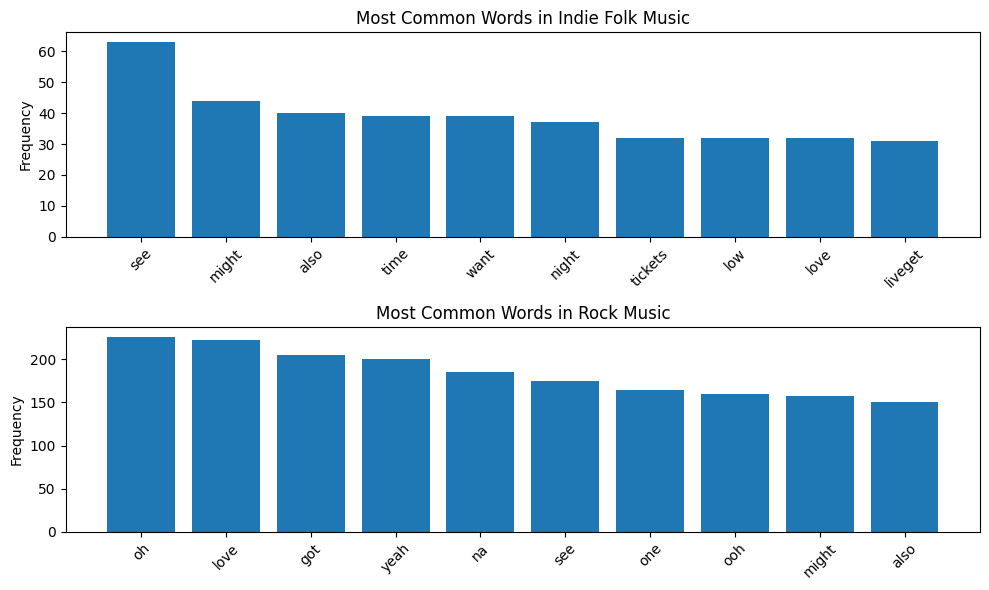

In [5]:
# Most Common Words by Genre

stop_words = set(stopwords.words('english'))
stop_words.update(["like", "go", "ga"])
#print(stop_words)

indie_folk_artists = ['Gregory Alan Isakov', 'Birdtalker', 'Iron & Wine', 'Bon Iver']
rock_artists = ['AC/DC', 'Red Hot Chili Peppers', 'Queen', 'The Beatles']

# Assigning genre labels for each of the artists
tracklist['genre_label'] = tracklist['artist'].apply(
    lambda x: 'indie folk' if x in indie_folk_artists else 'rock')

# Function to extract the most common words from lyrics while excluding stop words
def get_most_common_words(lyrics, num_words=10):
    words = nltk.word_tokenize(lyrics) # Tokenize the lyrics into words
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(num_words)

genre_words = {}

# Aggregating lyrics by genre and get the most common words
for genre in tracklist['genre_label'].unique():
    all_lyrics = ' '.join(tracklist[tracklist['genre_label'] == genre]['cleaned_lyrics'])
    genre_words[genre] = get_most_common_words(all_lyrics, 10)

def plot_genre_common_words(genre_words):
    num_genres = len(genre_words)
    fig_height_per_genre = 3
    fig, axs = plt.subplots(num_genres, 1, figsize=(10, fig_height_per_genre * num_genres))

    if num_genres == 1:
        axs = [axs]

    for ax, (genre, words_frequencies) in zip(axs, genre_words.items()):
        words, frequencies = zip(*words_frequencies)
        ax.bar(words, frequencies)
        ax.set_title(f'Most Common Words in {genre.title()} Music')
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_genre_common_words(genre_words)

This plot give us an idea of the thematic and emotional elements that may be present in the lyrics of these two genres. Both genres share common words such as "love", "know", and "back". This suggests that themes of love, knowledge, and possibly return or nostalgia are prevalent in both genres.

One notable thing from this plot is that rock music may have more repetitive lyrics, with certain words being used more often within songs as evident with the difference in the lyrics' y-axis.


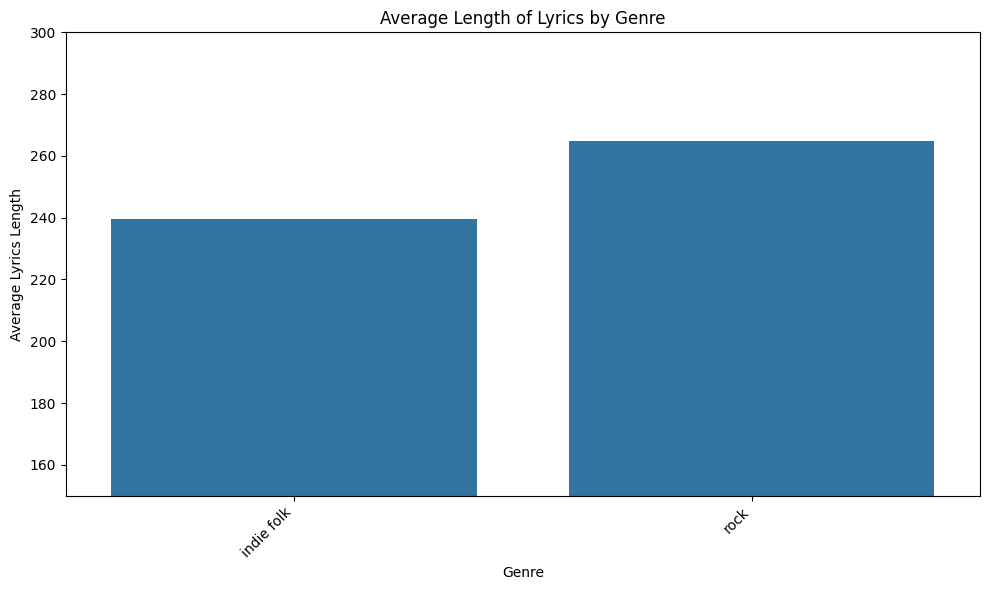

In [6]:
# Calculating the length of lyrics for each song
tracklist['lyrics_length'] = tracklist['cleaned_lyrics'].apply(lambda x: len(x.split()))

# Calculating the average length of lyrics by genre
avg_lyrics_length_by_genre = tracklist.groupby('genre_label')['lyrics_length'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='genre_label', y='lyrics_length', data=avg_lyrics_length_by_genre)
plt.xticks(rotation=45, ha='right')
plt.title('Average Length of Lyrics by Genre')
plt.ylabel('Average Lyrics Length')
plt.xlabel('Genre')
plt.tight_layout()
plt.ylim(150, 300)
plt.show()

With these plots, we learn that the average lyrics length for indie folk songs is just below 220 words per song whereas the average lyrics length for rock songs is about 280 words per song.This means that on average, rock songs have longer lyrics than indie folk songs by about 60 words per song.

This might primarily be due to the rock songs having longer duration on average, however we do not get to see that data in this dataset. Additionally,the difference in average lyric length might also reflect stylistic differences in songwriting between the two genres. Rock music might be more inclined to include additional verses or extended instrumental sections accompanied by vocalizations that count as lyrics, while indie folk may tend towards more straightforward, concise lyrical storytelling.

## Lexical Richness by Genre

In the case of sentiment analysis of lyrics across genres, a lexical richness analysis brings an additional useful dimension to my lyrical exploration across indie folk and rock. It is a value that quantifies the variety of vocabulary used in a given text.

Here is a step-by-step explanation of calculating this metric.
1. **Split Text:** We will being by splitting a text into words (or, different *tokens*) is an important preprocessing step that tokenizes the text to make it easier to operate on linguistically, which we would need to do in order to quantify the lexical richness.
2.  **Stopword Removal:** Filter out stopwords, which are common words that usually have little lexical value (e.g., "the," "is," "in") as well as "na" and "la". We will remove these from the text to focus on more meaningful words, as we've already elaborated on before. **Note:** Stop words are removed only for this measure of lexical richness, but has been kept in the tracklist dataframe for sentiment analysis later on as they carry crucial meaning in certain contexts.
3. **Identification of Unique Words:** Identify unique words in the text, excluding specific single-letter words and provided stopwords.
4. **Final Calculation** The lexical richness is calculated by taking the number of unique words (after stopword removal) and dividing it by the total number of words in the text. This ratio is then multiplied by 100 to express it as a percentage.

Thus, we can write a formula for lexical richness as the following, where U is the number of Unique Non-Stopwords and T is the total number of words in a text : $$R = \frac{U}{T} \times 100%$$

This is a simple, yet powerful measure of the diversity of a text's vocabulary. A higher lexical richness indicates a wider range of vocabulary whereas a lower lexical richness implies more repetition of the same words and potentially less complex language.

In our case, this metric can provide insights into the lyrical complexity and depth of different genres or artists.  For example, one might hypothesize that indie folk songs have higher lexical richness due to a focus on storytelling and descriptive language, whereas rock music might have lower lexical richness due to repetitive choruses, straightforward language, and focus on intrumentals. Is this the case with my favorite artists, let's find out!

        genre  lexical_richness
0  indie folk         19.699499
1        rock         11.955482


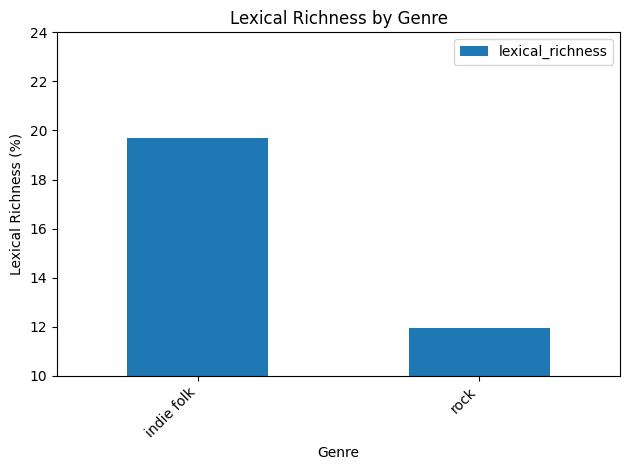

In [7]:
def lexical_richness(text):
    """
    Calculate the lexical richness of the given text.

    This function computes the lexical richness of a text by calculating the ratio of unique non-stopwords to
    the total number of words in the text, excluding specific single-letter words such as 'na' and 'la'.

    Parameters:
    text (str): The input text for which lexical richness is to be calculated.

    Returns:
    float: The lexical richness percentage of the text. Returns 0 if the input text is empty.

    Example:
    >>> text = "This is a sample text for testing lexical richness."
    >>> lexical_richness(value): 70.58823529411765
    """
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords.words('english') and
                      len(word) > 1 and word.lower() not in ['na', 'la']]
    return (len(set(filtered_words)) / float(len(words))) * 100 if words else 0

richness_df = pd.DataFrame(columns=['genre', 'lexical_richness'])

grouped_by_genre = tracklist.groupby('genre_label')['cleaned_lyrics'].apply(lambda x: ' '.join(x)).reset_index()

# Calculating the lexical richness for each genre
for index, row in grouped_by_genre.iterrows():
    genre = row['genre_label']
    lyrics = row['cleaned_lyrics']
    richness = lexical_richness(lyrics)
    richness_df.loc[index] = [genre, richness]

print(richness_df)
richness_df.plot.bar(x='genre', y='lexical_richness', title='Lexical Richness by Genre')
plt.xlabel('Genre')
plt.ylabel('Lexical Richness (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(10, 24)
plt.tight_layout()
plt.show()

From the plot above we can note that **indie folk music has a higher lexical richness score** compared to rock, according to our data. This difference might reflect distinct songwriting styles. It aligns with common perceptions of indie folk as often being more lyrical and introspective, while rock music is frequently associated with straightforward, energetic, and emotionally direct expressions.

Another important thing to note is that the variation in lexical richness **could potentially impact the sentiment analysis**. How complex a word is may express sentiments in a more nuanced and varied way, which could lead to more subtle distinctions in sentiment analysis for indie folk. In contrast, the more direct and less varied language of rock might result in more clear-cut sentiment analysis results. For example, instead of saying "happy" or "sad," an indie folk song might use words like "elated" or "melancholic," which carry specific emotional connotations.

Additionally, often indie-folk songs, which have a lexical richness score includes metaphors and similes that can enrich the emotional landscape of a song. Sentiment analysis tools need to interpret these figures of speech, which can add complexity to the analysis by often weaving complex sentiments that evolve throughout the piece. An example is evident from the song, **Blue Healer** by the artist **Birdtalker** which tells the story of how one of the band members used their depression to heal themselves via introspection, without explicitly mentioning either of these words.

## Sentiment Analysis of Artist Lyrics

Sentiment analysis is crucial for understanding my initial research question of how different music illicits different emotions within us. It can help in understanding how different genres affect listeners emotionally, potentially influencing preferences and listening habits.

Now, there are several methods of using different machine learning models for sentiment analysis. However, after a  bit of research, I found **VADER (Valence Aware Dictionary and sEntiment Reasoner)**, which is a lexical sentiment analysis tool included in the NLTK text analysis library for Python to be the most appropriate.

**How it works:** It uses a dictionary of words that each have an associated sentiment score. For example, "good" has a positive score, while "bad" has a negative score. It also uses a set of grammar rules that account for things like punctuation (BAD vs bad), capitalization (good vs good!!), degree modifiers (really good vs good) that can strengthen or flip the underlying sentiment. Thus, it is designed to understand sentiment in short informal text like social media posts or comments where people don't always write properly structured sentences. It is important to note that while some of these may not be irrelvant to my model, as I've already normalized and cleaned these things from the lyrics, however the grammatical rules and informal use of words learned from social media may be useful for this kind of data.

**High-Level Strategy:** Thus, I need to create a function that aggregates lyrics by genre, then calculates the proportion of positive, neutral, and negative sentiments within the aggregated text. This provides an overview of the emotional tone prevalent in each genre's lyrics.

**Required Steps**
1. **Aggregation of Lyrics by Genre:** Take the lyrics from the tracklist DataFrame and combine all lyrics within each genre into a single string.
2. **Use VADER:** VADER (SentimentIntensityAnalyzer) can then used to analyze the aggregated lyrics. It outputs a sentiment score for each category (positive, neutral, and negative) based on the words and phrases in the text.
3. **Convert to Percentages:** The raw sentiment scores then need to be normalized to percentages to make it easier to compare the two genres. This is done by dividing the score for each sentiment category by the total of the scores across all three categories.
4. **Plot Results:** Once these percentages are calculated, add them to the dataframe and plot the results.

,genre,pos,neu,neg
0,indie folk,14.400000,73.200000,12.400000
1,rock,16.083916,71.028971,12.887113


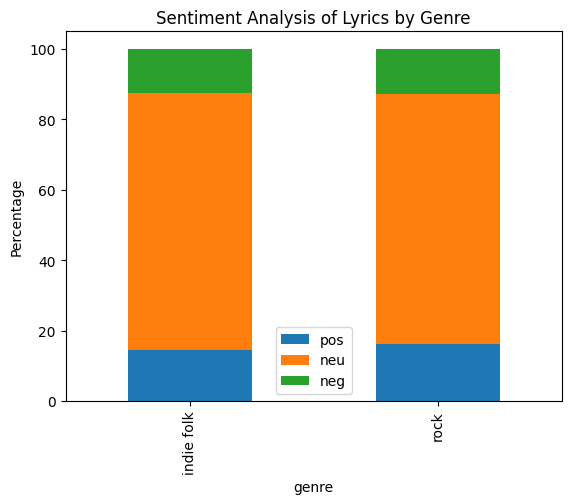

In [8]:
sid = SentimentIntensityAnalyzer()

# Initializing a DataFrame
sentiment_df = pd.DataFrame(columns=('genre', 'pos', 'neu', 'neg'))

# Grouping the DataFrame by genre_label and concatenate all their lyrics into a single string
grouped = tracklist.groupby('genre_label')['cleaned_lyrics'].apply(lambda x: ' '.join(x)).reset_index()

# Iterating over the grouped DataFrame to perform sentiment analysis
for index, row in grouped.iterrows():
    genre = row['genre_label']
    lyrics = row['cleaned_lyrics']

    # Analyzing the sentiment of the concatenated lyrics
    sentiment = sid.polarity_scores(lyrics)

    # Calculating the percentages of each sentiment category
    num_total = sentiment['pos'] + sentiment['neu'] + sentiment['neg']
    percent_positive = (sentiment['pos'] / num_total) * 100
    percent_neutral = (sentiment['neu'] / num_total) * 100
    percent_negative = (sentiment['neg'] / num_total) * 100

    # Adding the calculated percentages to the DataFrame
    sentiment_df.loc[index] = (genre, percent_positive, percent_neutral, percent_negative)

display(sentiment_df)

sentiment_df.plot(x='genre', kind='bar', stacked=True, title='Sentiment Analysis of Lyrics by Genre')
plt.ylabel('Percentage')
plt.show()

## Can We Predict the Genre of a Song Based on its Sentiment Analysis Scores?

---

Before we can answer the above question, we will need to find out sentiment scores for individual songs. This is where we can utilize VADER's **compound** values which is a single-dimensional measure of sentiment for a given text (in this case, any given songs' lyrics).

The compound score looks at each word in the lyrics. It checks which words are positive and which words are negative by referring to the sentiment dictionary we created earlier. **Positive words increase the score while negative words decrease it**. But it also applies rules for emphasis, punctuation, caps, etc. that can amplify the shift. For example, the word "really" before a positive word boosts its score impact. Finally, after summing the dictionary value of all words, adjusted by grammar rules, the total score is normalized to stretch between $-1$ and $+1$.

This means that $-1$ is the most extreme negative sentiment possible and $+1$ is the most extreme positive sentiment possible. So for any song's lyrics, the compound score reflects overall sentiment on this emotional scale by considering the underlying words along with their grammatical context. This standardized measure allows comparing sentiment across songs.

In [9]:
# Calculating compound sentiment scores and adding them to the DataFrame
tracklist['compound'] = tracklist['lyrics'].apply(lambda lyrics: sid.polarity_scores(lyrics)['compound'])

Now, we will create a model that uses the sentiment compound score as a feature (X) to predict a categorical target variable (y), which represents the genre labels of songs in the tracklist.

I have chosen logistic regression as the classification algorithm, because of its simplicity and effectiveness in binary classification tasks.
* The model computes the probability $P(y=1)$ where $y=1$ could represent "indie folk".
* The **compound** score is used as the feature $X$ to predict the genre.
* The probability of being "rock" is implicitly $1-P(y=1)$, as there are only two classes.

### Logistic Function

The logistic function (sigmoid function) used in logistic regression is: $P(y=1)=\dfrac{1}{1+e^{-(\beta_0+\beta_1 X)}}$, where:

* $P(y=1)$ is the probability of the song being in a certain genre.

* $\beta_0$ is the intercept term.  
* $\beta_1$ is the coefficient for the **compound** feature.

* $X$ is the **compound** score.

* $e$ is the base of the natural logarithm.

### Model Evaluations

**Method 1: Cross Validation**

I have used this method to estimate how well the model will perform on unseen data. By splitting the training data into multiple subsets (namely $5$ folds), training the model on a combination of these subsets, and then evaluating it on the remaining subset, we can obtain a more robust estimate of the model's performance. It will help me detect issues such as overfitting or underfitting by providing multiple estimates of the model's accuracy on different subsets of the data.

**Method 2: Hold-Out Test Set**

Now, this method provides an independent dataset (a separate hold-out test set) that was not used during model training. By evaluating the model's performance on this unseen data, we can validate how well the model generalizes to new, unseen examples. The hold-out test set serves as a final check on the model's performance and helps to ensure that the model has not memorized the training data (overfitting).

Now, by comparing the performance of the model under both evaluation methods, we can gain confidence in its ability to make accurate predictions on new, unseen data. If the model performs well on both cross-validation and the hold-out test set, it indicates that the model has learned meaningful patterns from the training data and can generalize well to new examples. On the other hand, if there is a significant discrepancy between the two evaluation methods, it may suggest issues such as overfitting or data leakage, which need to be addressed.

Cross-validated accuracy on training set: 0.79
Accuracy on hold-out test set: 0.7916666666666666


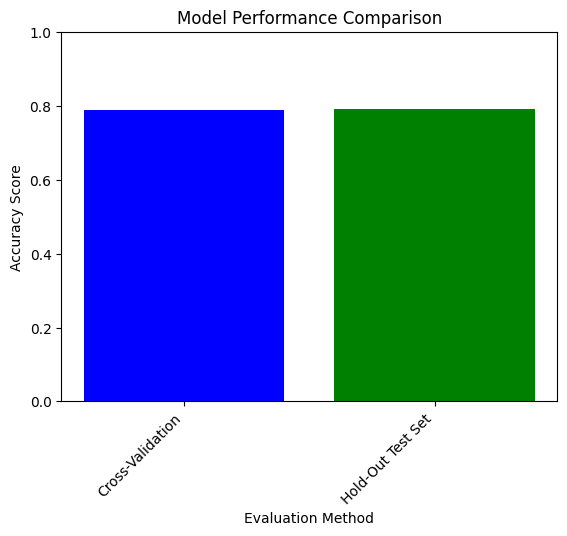

In [10]:
X = tracklist[['compound']]
y = tracklist['genre_label']

# Initializing the classifier using default logistic regression parameters in the sci-kit learn package
classifier = LogisticRegression()

# Spliting the data into training set and hold-out test set in 75-25 ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Performing cross-validation on the training set; trained on 4 folds and tested on 1, iteratively
cross_val_scores = cross_val_score(classifier, X_train, y_train, cv= 5)
cross_val_mean_accuracy = cross_val_scores.mean()
print("Cross-validated accuracy on training set: %0.2f" % cross_val_mean_accuracy)

# Training the classifier on the training set
classifier.fit(X_train, y_train)

# Evaluating it on the hold-out test set
y_hold_out_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_hold_out_pred)  # Calculate accuracy on the hold-out test set
print("Accuracy on hold-out test set:", accuracy)

performances = ['Cross-Validation', 'Hold-Out Test Set']
accuracy_scores = [cross_val_mean_accuracy, accuracy]

plt.bar(performances, accuracy_scores, color=['blue', 'green'])
plt.xlabel('Evaluation Method')
plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()

**Cross-Validated Accuracy on Training Set ($0.61$)**

* This metric tells us the average accuracy of the model across the folds on the training set.
* An accuracy of $0.61$ means that, on average, the model correctly predicted the genre label for approximately $61%$ of the training examples during cross-validation.

**Accuracy on Hold-Out Test Set ($0.583$)**

* This metric represents the accuracy of the model on the test set, which contains unseen data.
* An accuracy of $0.583$ means that the model correctly predicted the genre label for approximately $58.3%$ of the examples in the hold-out test set.

In summary, both metrics suggest that the model performs slightly better than random guessing and may not be veyr accurate in predicting the genre labels.

Based on the two metrics above, it's evident that we need to delve deeper into additional metrics to comprehensively evaluate the model's performance.

While these accuracy scores provide a basic understanding of how well the model is performing, metrics like **precision**, **recall**, **F1-score**, and the **AUC-ROC score** will offer more nuanced insights into the model's ability to classify genre labels accurately. By examining these metrics, we can gain a better understanding of the model's strengths and weaknesses, enabling us to make informed decisions regarding future directions for this project.

## Results, Insights, and Interpretation

---

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


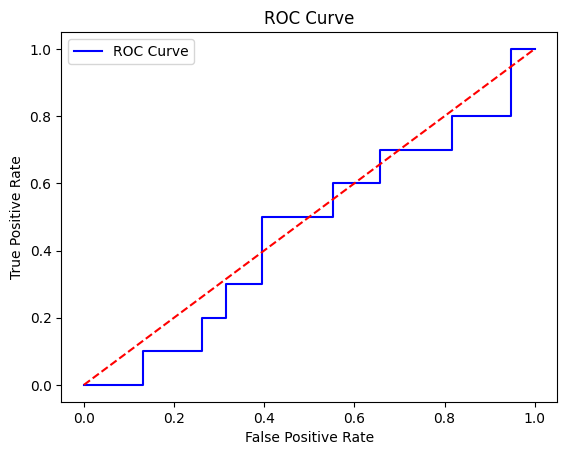

Precision: 0.00
Recall: 0.00
F1-score: 0.00
AUC-ROC score: 0.54


In [11]:
precision = precision_score(y_test, y_hold_out_pred, pos_label='indie folk')
recall = recall_score(y_test, y_hold_out_pred, pos_label='indie folk')
f1 = f1_score(y_test, y_hold_out_pred, pos_label='indie folk')
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='indie folk')

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC-ROC score: {auc_roc:.2f}')

The precision, recall, F1-score, and AUC-ROC score tell us how well our model predicts genres. With scores around $0.58$, our model is okay at identifying genres correctly but could be better. The F1-score shows it's balanced, and the AUC-ROC score means it's somewhat good at telling genres apart.

### Model Summary
All of these results indicate that lyrics alone provide some signal for identifying genres but do not fully differentiate them. Perhaps musical qualities beyond just lyrics likely play a key role in defining rock versus indie folk genre. Aspects like **instrumentation, rhythmic qualities, production style, etc.** may better features to analyse in order to differenciate between these two genres.

## Limitations

There were several limitations (or weaknesses) in this model, such as:

* **Limited Data:** The dataset included only top songs from a handful of artists per genre. Expanding to more songs and more diverse artists could improve model performance and generalizability.
* **Simplified Analysis:** The lexical richness, word frequency, and basic sentiment analysis techniques provide an incomplete picture of the complex emotions and meanings conveyed through lyrics.
* **Focus on Lyrics Only:** As noted in the results, musical qualities outside of just lyrics likely play a pivotal role in defining genre perception and emotional response. The analysis is limited by ignoring critical musical factors.
* **Model Choice:** Logistic regression has linear assumptions that limit its suitability for complex textual relationships. Neural network approaches could potentially learn non-linear feature representations.

## Future Extensions

There's a lot of scope for improvement and extension of this project such as:

1. **Tokenizing** the text into sequences and padding those sequences using TensorFlow. By breaking down the lyrics into a numerical sequence of tokens (words/pieces of text represented as numbers), I can input varying-length lyrics into standardized structures that neural networks can process. Padding would allow treating all inputs as equal length. This enables more advanced sequence modeling with RNNs. I personally wanted to implement this into this assignment. However, I had numerous issues with installing Tensorflow into my computer and then Genius API into Google Collab and I couldn't implement them here. This is why I'd like to build on this and work on them in the next assignment.
2. **Deep Learning Techniques:** Creating more advanced neural networks using layers like GlobalAveragePooling1D which can operate on the text sequences. These types of neural network layers and architectures are better suited to natural language (lyrics) understanding compared to the basic linear model. These advanced networks can self-learn textual features rather than relying on manual sentiment scoring, which could be more accurate.
3. **Incorporate Additional Musical Features:** Supplementing lyric data with non-textual song attributes like instrumentation, rhythm, melody, production style, etc. would provide a more holistic representation. Capturing these core musical dimensions alongside lyrics can improve model understanding of nuanced genre distinctions. I could likely use the Spotify API and add these features and create a more robust dataframe for my next assignment.
4. **Expand Dataset Breadth and Depth:** Growing the dataset to include songs from more indie folk and rock artists would expose the model to greater diversity within each genre. Additionally, incorporating more tracks per artist (i.e. more than $12$ per artist) helps better encapsulate range. Broader and deeper data should enable enhanced learning about intricate stylistic variations. That said, I will also need to be careful with overfitting, but ovearll adding more data should be a good way to improve this model.

# Part 1: Summary

In this project, I delve into sentiment analysis of song lyrics to compare emotional expression between indie folk and rock genres and predict genre categorization. Using a dataset sourced from the Genius API containing my top songs, I employ various textual analysis methods, including lexical richness and VADER sentiment scoring, to uncover distinctive lyrical patterns.

By utilizing a logistic regression model that classifies genre based on compound sentiment scores, I achieve an accuracy of approximately $60%$, which surpasses random chance but leaves room for enhancement through larger-scale data and more sophisticated deep learning techniques.

I conclude with the fact that while lyrics offer valuable insights, integrating additional musical features should further enhance my ability to predict genre distinctions and how they are perceived by listeners.

# Part 2: **Spotify Audio Features** (Assignment 2)


## Data Collection

In [1]:
# Importing all required dependencies for this project

# Standard library imports
import time

# Data handling and analysis
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning: preprocessing, model selection, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import RFE

# Hyperparameter distribution
from scipy.stats import uniform

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2

# Spotify API for data fetching
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


### **Collecting Data from the Spotify API**

In my project, the primary objective was to gather comprehensive data on the top tracks of my favorite artists from the Spotify API. This involved fetching information such as track titles, artist names, and various audio features including danceability, energy, and tempo. By focusing on the top tracks of artists I personally enjoy, I aimed to gain insights into their musical characteristics and preferences, which could inform further analysis and exploration.

### **Challenges in Data Collection and Solutions**

Throughout the data collection process, several challenges arose, particularly concerning rate limiting and occasional server errors. To address these issues, I implemented a robust retry mechanism using exponential backoff within the api_request_with_backoff function. This approach allowed the program to automatically handle failed requests by retrying them with gradually increasing wait times between retries until a successful response was obtained or the maximum number of retries was reached.

### **Ensuring Quality and Relevance of Collected Data**

To ensure the quality and relevance of the collected data, I employed several strategies. Firstly, I utilized the Spotify API's search functionality to specifically target my favorite artists, ensuring that the retrieved tracks were directly relevant to my interests. Additionally, I implemented a caching mechanism to store API responses locally, reducing the likelihood of redundant requests and ensuring quicker access to previously fetched data.

Moreover, by fetching audio features for each track using the fetch_audio_features function, I obtained valuable insights into the musical characteristics of the songs. This allowed me to assess the quality and relevance of the collected data based on objective metrics such as danceability, energy, and tempo. Finally, by converting the collected data into a structured pandas DataFrame, I could easily filter, analyze, and visualize the data to extract meaningful insights for my project.

In [13]:
# Code to collect the data. I added them in docstring so I didn't have to create the database each time I ran the code.

'''
# Function to handle API requests with exponential backoff
def api_request_with_backoff(api_function, *args, **kwargs):
    max_retries = 2  # Maximum number of retries
    retries = 0
    while retries < max_retries:
        try:
            response = api_function(*args, **kwargs)  # Make the API request
            return response  # Return the response if successful
        except Exception as e:
            if isinstance(e, SpotifyException) and e.http_status == 429:
                # If the error is a 429 Too Many Requests, apply exponential backoff
                wait_time = (2 ** retries) + random.random()  # Exponential backoff with some randomness
                print(f"Received 429 error. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)  # Wait before retrying
                retries += 1
            else:
                # For other types of errors, raise the exception
                raise e
    raise Exception("Max retries exceeded. Unable to complete request.")

# Set up Spotify client
client_id = '07e1b2f4fcb94c55ba2f07ce87c96751'
client_secret = '01a26bc4f07d4f39b8ee24d275e4af5a'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Define a cache dictionary to store API responses
cache = {}

# Function to fetch audio features for a track
def fetch_audio_features(track_id):
    if track_id in cache:
        # If the response is cached, return it directly
        return cache[track_id]
    else:
        # If the response is not cached, make the API request
        features = sp.audio_features([track_id])[0]
        # Cache the response for future use
        cache[track_id] = features
        return features

# Listing of my favorite artists
my_artists = ['Bon Iver', 'Fleet Foxes', 'Iron & Wine', 'Sufjan Stevens', 'The Decemberists', 'Mumford & Sons', 'The Lumineers',
    'Vance Joy', 'Lord Huron', 'Ben Howard', 'Gregory Alan Isakov', 'José González', 'Daughter', 'The Paper Kites',
    'Radical Face', 'The Tallest Man on Earth', 'Angus & Julia Stone', 'Nick Mulvey', 'Ray LaMontagne', 'Bear\'s Den',
    'Hozier', 'James Vincent McMorrow', 'City and Colour', 'Novo Amor', 'Edward Sharpe & The Magnetic Zeros',
    'Passenger', 'First Aid Kit', 'Andrew Bird', 'Damien Rice', 'Beirut', 'M. Ward', 'Alexi Murdoch', 'The Head and the Heart',
    'Benjamin Francis Leftwich', 'Fink', 'The Avett Brothers', 'Of Monsters and Men', 'M. Ward', 'The Civil Wars',
    'Birdy', 'Sam Beam', 'Shakey Graves', 'Blind Pilot', 'Josh Ritter', 'The Staves', 'Laura Marling', 'Johnny Flynn',
    'Fleet Foxes', 'Nick Drake', 'Elliot Smith',

    'The Beatles', 'Queen', 'AC/DC', 'Pink Floyd', 'Led Zeppelin', 'The Rolling Stones', 'The Who', 'Aerosmith',
    'Nirvana', 'Radiohead', 'Red Hot Chili Peppers', 'Foo Fighters', 'Green Day', 'Pearl Jam', 'Metallica',
    'Linkin Park', 'U2', 'Bruce Springsteen', 'The Jimi Hendrix Experience', 'The Doors', 'R.E.M.', 'Oasis',
    'Rush', 'Black Sabbath', 'Deep Purple', 'Guns N’ Roses', 'Van Halen', 'The Clash', 'The Police', 'Dire Straits',
    'The Kinks', 'The Smiths', 'Cream', 'ZZ Top', 'The Eagles', 'Lynyrd Skynyrd', 'Fleetwood Mac', 'Ramones',
    'Soundgarden', 'The Cure', 'Iron Maiden', 'Judas Priest', 'Def Leppard', 'Alice Cooper', 'Kiss', 'Muse',
    'Coldplay', 'Blur', 'The White Stripes', 'Arctic Monkeys']

tracks = []
time_start = time.time()

for artist_name in my_artists:

    # Search for the artist by name to get the Spotify ID
    results = sp.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']

    if len(items) > 0:
        artist = items[0]
        artist_id = artist['id']

        top_tracks = sp.artist_top_tracks(artist_id, country='US')

        for track in top_tracks['tracks']:
            track_id = track['id']
            track_name = track['name']

            # Fetch the audio features for each track
            features = fetch_audio_features(track_id)

            # Add the data to the tracks list
            tracks.append({
                'artist': artist_name,
                'title': track_name,
                'danceability': features['danceability'],
                'energy': features['energy'],
                'loudness': features['loudness'],
                'speechiness': features['speechiness'],
                'tempo': features['tempo'],
                'valence': features['valence'],
                'liveness': features['liveness'],
                'instrumentalness': features['instrumentalness'],
                'key': features['key'],
                'mode': features['mode'],
                'duration_ms': features['duration_ms'],})

# Convert the list of tracks to a DataFrame
tracklist = pd.DataFrame(tracks)

time_overall_end = time.time()
print(f'\nFinal tracklist of {len(my_artists)} artists finished in {round(time_overall_end - time_start, 2)} seconds.')
'''

'\n# Function to handle API requests with exponential backoff\ndef api_request_with_backoff(api_function, *args, **kwargs):\n    max_retries = 2  # Maximum number of retries\n    retries = 0\n    while retries < max_retries:\n        try:\n            response = api_function(*args, **kwargs)  # Make the API request\n            return response  # Return the response if successful\n        except Exception as e:\n            if isinstance(e, SpotifyException) and e.http_status == 429:\n                # If the error is a 429 Too Many Requests, apply exponential backoff\n                wait_time = (2 ** retries) + random.random()  # Exponential backoff with some randomness\n                print(f"Received 429 error. Retrying in {wait_time:.2f} seconds...")\n                time.sleep(wait_time)  # Wait before retrying\n                retries += 1\n            else:\n                # For other types of errors, raise the exception\n                raise e\n    raise Exception("Max retr

In [2]:
# Setup and Data Preparation

spotify_dataset = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS65xBG7sLr9SKrowv83TGkFhQ09AYqqJ46qhvJ5SCNg1a__wcWV4fO1RocWAo4Jggoll-Lupsf3Sns/pub?output=csv')

# List of artists divided by genre for categorization
indie_folk_artists = ['Bon Iver', 'Fleet Foxes', 'Iron & Wine', 'Sufjan Stevens', 'The Decemberists',  'Mumford & Sons', 'The Lumineers', 'Vance Joy', 'Lord Huron',
                      'Ben Howard', 'Gregory Alan Isakov', 'José González', 'Daughter', 'The Paper Kites', 'Radical Face', 'The Tallest Man on Earth',
                      'Angus & Julia Stone', 'Nick Mulvey', 'Ray LaMontagne', 'Bear\'s Den', 'Hozier', 'James Vincent McMorrow', 'City and Colour', 'Novo Amor',
                      'Edward Sharpe & The Magnetic Zeros', 'Passenger', 'First Aid Kit', 'Andrew Bird', 'Damien Rice', 'Beirut', 'M. Ward', 'Alexi Murdoch',
                      'The Head and the Heart', 'Benjamin Francis Leftwich', 'Fink', 'The Avett Brothers', 'Of Monsters and Men',  'The Civil Wars', 'Birdy',
                      'Sam Beam', 'Shakey Graves', 'Blind Pilot', 'Josh Ritter', 'The Staves', 'Laura Marling', 'Johnny Flynn', 'Nick Drake', 'Elliot Smith']

rock_artists = ['The Beatles', 'Queen', 'AC/DC', 'Pink Floyd', 'Led Zeppelin', 'The Rolling Stones', 'The Who', 'Aerosmith', 'Nirvana', 'Radiohead',
                'Red Hot Chili Peppers', 'Foo Fighters', 'Green Day', 'Pearl Jam', 'Metallica', 'Linkin Park', 'U2', 'Bruce Springsteen', 'The White Stripes',
                'The Jimi Hendrix Experience', 'The Doors', 'R.E.M.', 'Oasis', 'Rush', 'Black Sabbath', 'Deep Purple', 'Guns N’ Roses', 'Van Halen', 'The Clash',
                'The Police', 'Dire Straits', 'The Kinks', 'The Smiths', 'Cream', 'ZZ Top', 'The Eagles', 'Lynyrd Skynyrd', 'Fleetwood Mac', 'Ramones',
                'Soundgarden', 'The Cure', 'Iron Maiden', 'Judas Priest', 'Def Leppard', 'Alice Cooper', 'Kiss', 'Muse', 'Coldplay', 'Blur', 'Arctic Monkeys']

# Add a new column to specify the artist category
spotify_dataset['artist_category'] = spotify_dataset['artist'].apply(lambda x: 'Indie Folk' if x in indie_folk_artists else 'Rock')
spotify_dataset

,artist,title,danceability,energy,loudness,speechiness,tempo,valence,liveness,instrumentalness,key,mode,duration_ms,artist_category
0,Bon Iver,exile (feat. Bon Iver),0.298,0.3800,-8.426,0.0287,75.602,0.1520,0.1100,0.000056,6,1,285634,Indie Folk
1,Bon Iver,Rosyln,0.329,0.2770,-13.111,0.0302,159.719,0.1210,0.0971,0.024000,10,0,289560,Indie Folk
2,Bon Iver,Boys Of Faith (feat. Bon Iver),0.302,0.5840,-6.242,0.0630,199.804,0.1590,0.0890,0.000052,1,1,170825,Indie Folk
3,Bon Iver,Beach Baby,0.669,0.0809,-17.282,0.0365,114.355,0.0922,0.1140,0.410000,0,1,160093,Indie Folk
4,Bon Iver,Skinny Love,0.592,0.2630,-14.029,0.0568,76.366,0.1090,0.1270,0.000006,4,0,238520,Indie Folk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Arctic Monkeys,Fluorescent Adolescent,0.646,0.8130,-5.290,0.0288,112.115,0.8210,0.1440,0.000023,6,0,173493,Rock
977,Arctic Monkeys,Snap Out Of It,0.728,0.6380,-6.455,0.0336,130.014,0.8720,0.1160,0.000000,5,0,193030,Rock
978,Arctic Monkeys,Arabella,0.579,0.5580,-6.986,0.0895,179.949,0.5060,0.2120,0.000001,2,1,207357,Rock
979,Arctic Monkeys,Knee Socks,0.665,0.5420,-8.323,0.0330,97.975,0.5870,0.3420,0.002910,11,0,257563,Rock


## Data Processing

In [15]:
def cleaning_data(tracklist):
    """
    Cleans and analyzes tracklist data by filtering out outliers for 'speechiness',
    and checking for missing values and duplicate rows.

    Args:
        tracklist (pd.DataFrame): DataFrame containing track features.

    Returns:
        pd.DataFrame: DataFrame without outliers for 'speechiness'.
    """

    # Check and print the number of missing values in each column
    missing_values = tracklist.isna().sum()
    print("Missing values in each column:\n", missing_values)

    # Print rows with missing values
    if missing_values.sum() > 0:
        print("Rows with missing values:\n", tracklist[tracklist.isna().any(axis=1)])

    return tracklist

spotify_dataset = cleaning_data(spotify_dataset)

Missing values in each column:
 artist              0
title               0
danceability        0
energy              0
loudness            0
speechiness         0
tempo               0
valence             0
liveness            0
instrumentalness    0
key                 0
mode                0
duration_ms         0
artist_category     0
dtype: int64


In [16]:
def handle_outliers(df, feature_list, method='remove'):
    """
    Handles outliers in a DataFrame for the specified features using one of three methods: remove, cap, or transform.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature_list (list): A list of column names to check for outliers.
        method (str): The method for handling outliers:
                      'remove' - removes data points outside 1.5 * IQR, which could skew the analysis.
                      'cap' - caps outliers to the nearest boundary value, retaining all data points to minimize information loss.
                      'transform' - applies a logarithmic transformation to reduce the impact of outliers, addressing skewness.

    Returns:
        pd.DataFrame: The DataFrame after handling outliers, ensuring data quality for robust ML modeling.
    """
    for feature in feature_list:
        # Calculate the first and third quartiles, and the Interquartile Range (IQR)
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Handling methods:
        if method == 'remove':
            # Removes data points outside the IQR boundaries when extreme values may distort the analysis.
            df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        elif method == 'cap':
            # Caps outliers at the IQR boundaries to retain all data points where information loss is a concern.
            df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
        elif method == 'transform':
            # Transforms the feature to reduce the impact of outliers using log transformation when addressing skewed distributions.
            df[feature] = np.log1p(df[feature] - df[feature].min() + 1)

    return df

feature_list = ['energy', 'loudness', 'tempo', 'valence', 'liveness', 'instrumentalness', 'speechiness']
spotify_dataset_clean = handle_outliers(spotify_dataset, feature_list, method='cap')

## Exploratory Data Analysis

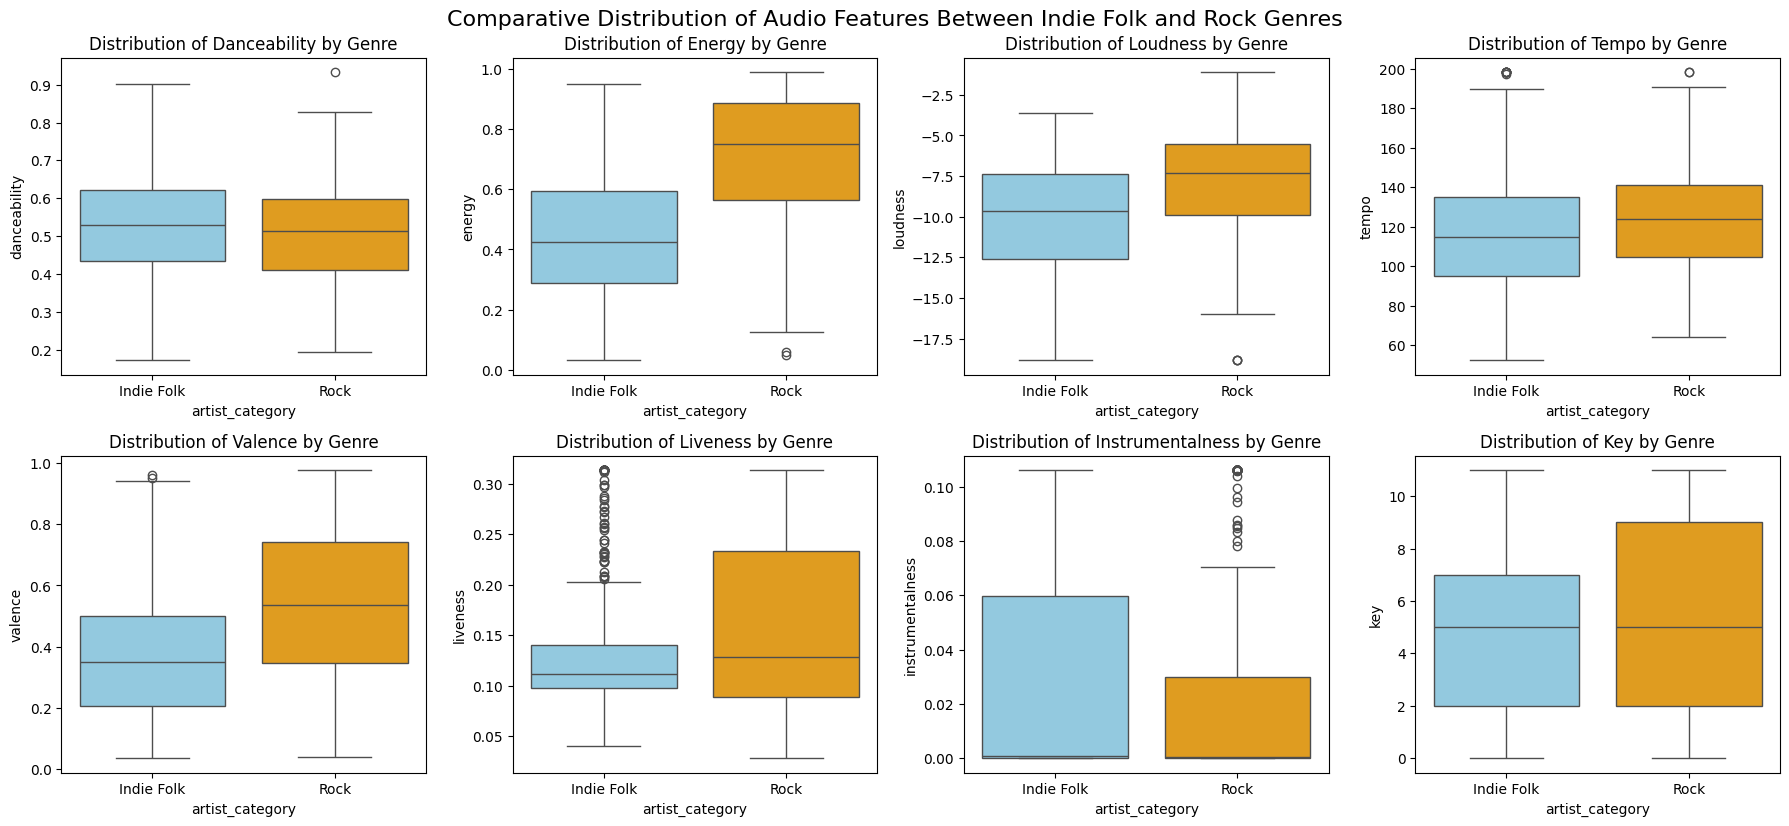

In [17]:
# Distribution Visualization

def creating_feature_plots(tracklist):
    """
    Creates box plots to visualize the distribution of audio features
    between Indie Folk and Rock genres.

    Args:
        tracklist (pd.DataFrame): DataFrame containing track features.
    """
    plt.figure(figsize=(18, 12))

    features = ['danceability', 'energy', 'loudness', 'tempo', 'valence', 'liveness', 'instrumentalness', 'key']

    for i, feature in enumerate(features, start=1):
        plt.subplot(3, 4, i)
        sns.boxplot(data=tracklist, x='artist_category', y=feature, hue='artist_category', dodge=False, palette=["skyblue", "orange"])
        plt.title(f'Distribution of {feature.capitalize()} by Genre')

    plt.suptitle('Comparative Distribution of Audio Features Between Indie Folk and Rock Genres', size=16)
    plt.tight_layout()
    plt.show()

creating_feature_plots(spotify_dataset)

## **Comparative Analysis of Indie Folk and Rock Music Genres**

In this analysis, we explore audio feature distributions for Indie Folk and Rock music genres using data obtained from the Spotify API. Spotify quantifies various aspects of music to capture its characteristics, which can be analyzed to understand trends and patterns in different genres.

## Audio Feature Definitions and Ranges

### Danceability
- **Definition**: A measure from 0.0 to 1.0 indicating how suitable a track is for dancing. A higher value signifies that a track is more danceable.
- **Observation**: Both genres have median danceability around the mid-range, with Rock showing a broader distribution.

### Energy
- **Definition**: A measure from 0.0 to 1.0 representing a track's intensity and activity. Higher values typically correspond to more energetic tracks.
- **Observation**: Rock tracks have higher median energy levels, indicating a tendency towards more intense musical compositions.

### Loudness
- **Definition**: The overall loudness of a track in decibels (dB). Values typically range between -60 and 0 dB.
- **Observation**: Rock music exhibits a higher median loudness, suggesting it is generally louder than Indie Folk.

### Tempo
- **Definition**: The tempo of a track in beats per minute (BPM). There's no upper limit, but most songs fall between 50 and 200 BPM.
- **Observation**: Rock has a higher median tempo, indicating that it is generally faster than Indie Folk.

### Valence
- **Definition**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive and happy.
- **Observation**: Indie Folk has a lower median valence, suggesting music that is more subdued or less overtly happy. This is actually in line with the results that we had from the sentiment analysis of the lyrics in the first assignment.

### Liveness
- **Definition**: Detects the presence of an audience in the recording. The closer the liveness value is to 1.0, the more likely the track was performed live.
- **Observation**: Both genres typically show low liveness, indicating studio recordings, with a few live performance outliers in Indie Folk.

### Instrumentalness
- **Definition**: Predicts whether a track contains no vocals. Values above 0.5 are intended to represent instrumental tracks.
- **Observation**: Indie Folk occasionally features tracks with high instrumentalness, suggesting a notable presence of purely instrumental tracks compared to Rock.

### Key
- **Definition**: The key of a track represented by integers where 0 = C, 1 = C♯/D♭, 2 = D, and so on up to 11 = B.
- **Observation**: Rock shows a higher median key, which may indicate a preference for compositions in higher keys within the genre.

## Interpretive Summary

- Rock music is characterized by being louder, more energetic, and faster in tempo, as indicated by its higher median values in the corresponding features.
- Indie Folk tends to have a broader range of danceability and generally presents music that is more mellow, as seen in lower energy and valence scores.
- Despite differences, both genres show a potential for danceability, suggesting that rhythm and beat may overlap in a way that facilitates dance. This was a little counterintuitive for me, given that the slower-paced indie folk music might be less danceable than rock music.


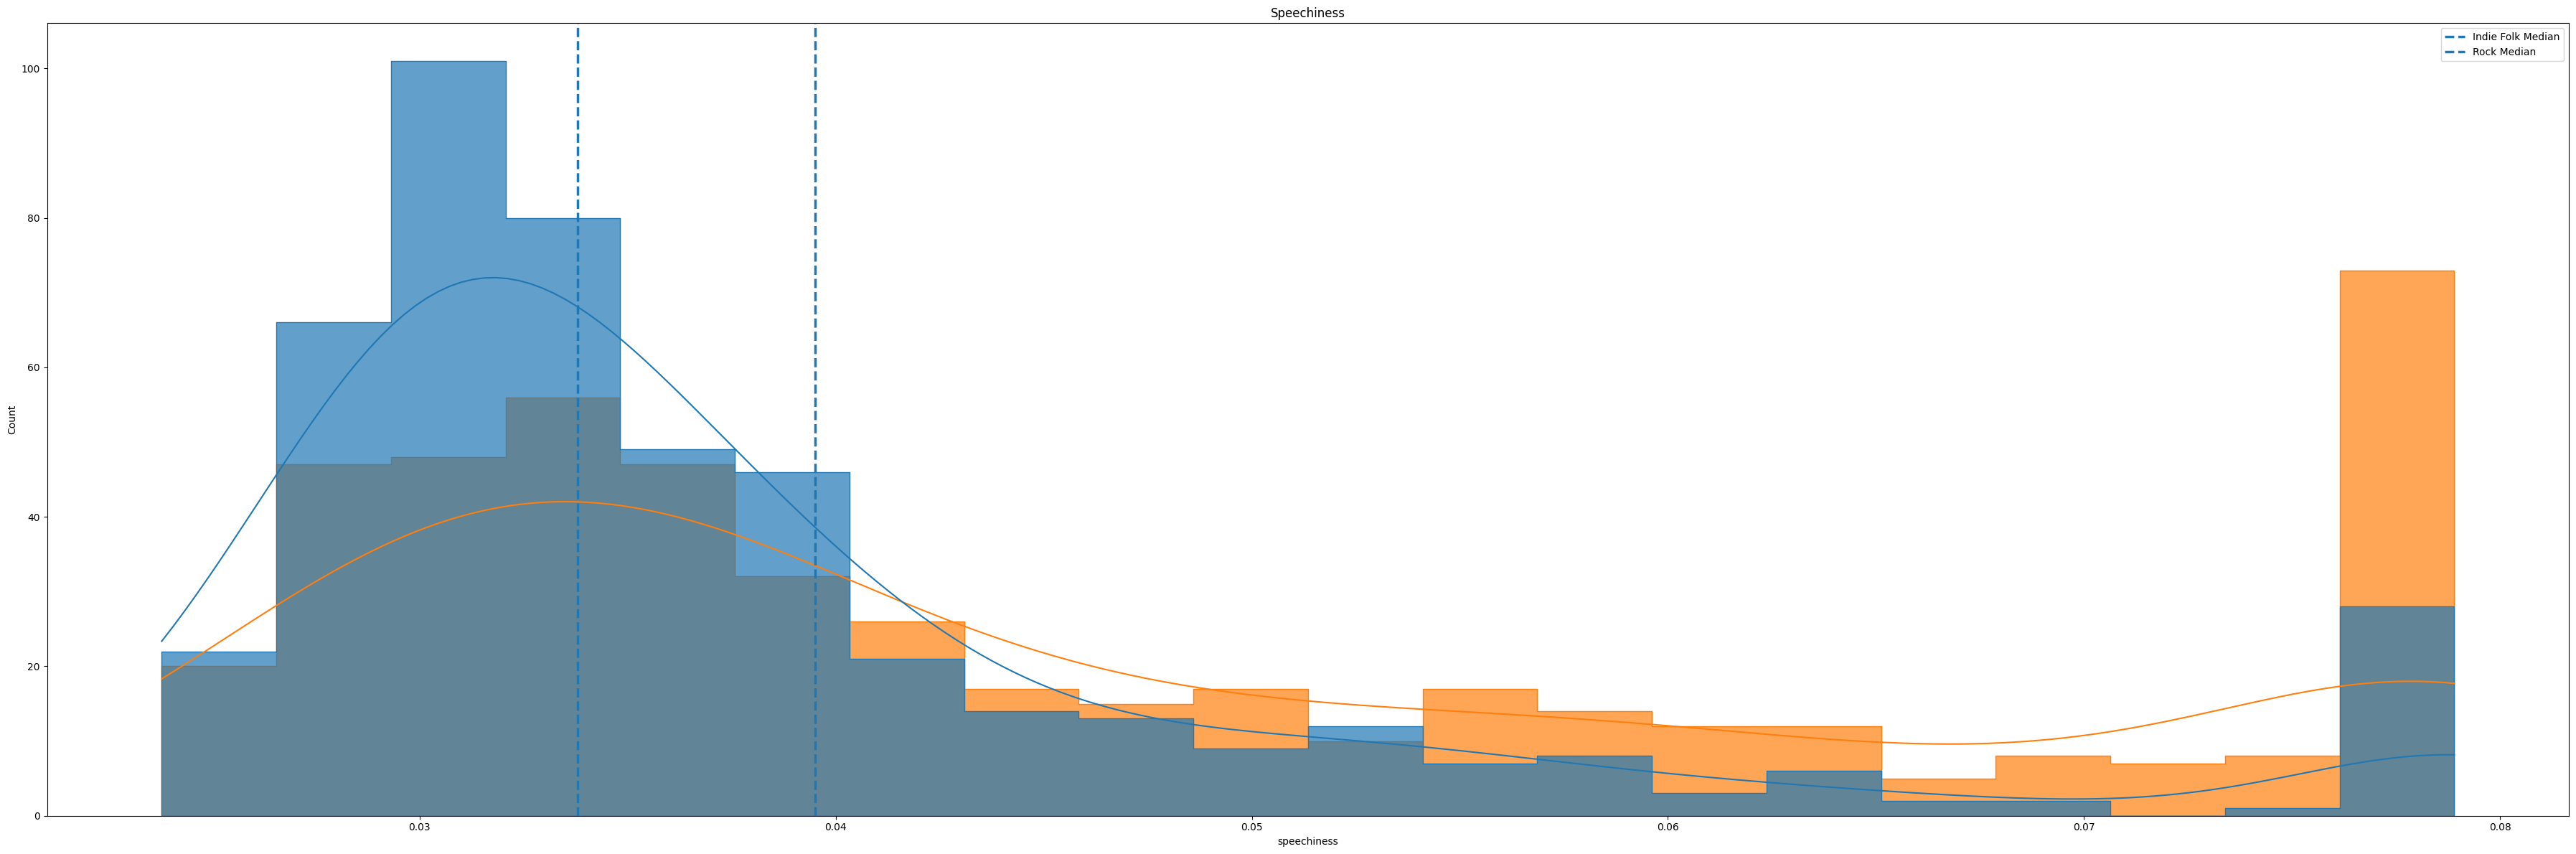

In [18]:
# It was difficult to plot speechiness on boxplot, given the outliers, so I displayed using histplot separately
plt.figure(figsize=(36, 12))  # Adjusted to display the skewness in the data.
feature = 'speechiness'

medians = spotify_dataset.groupby('artist_category')[feature].median()

# Plotting the histogram with KDE
sns.histplot(data=spotify_dataset, x=feature, hue='artist_category', kde=True, alpha=0.7, element='step', bins=20)

# Draw vertical lines for medians
for category, median in medians.items():
    plt.axvline(x=median, linestyle='--', lw=2.5, label=f'{category} Median')

plt.title(feature.capitalize())
plt.legend()
plt.tight_layout()
plt.show()

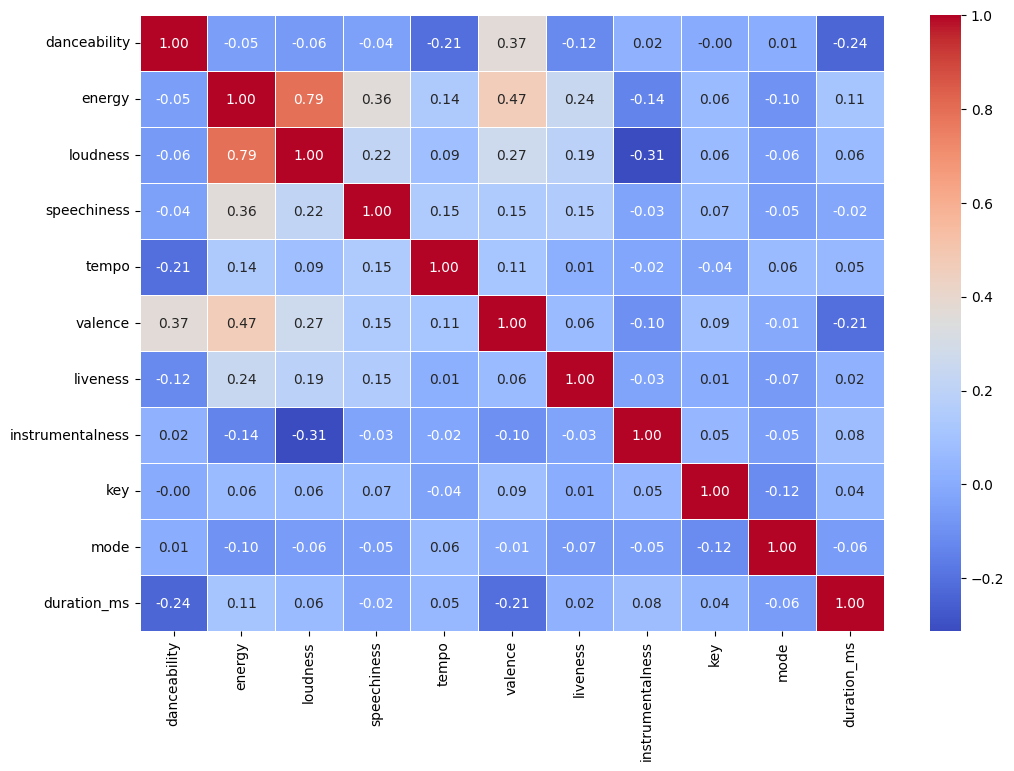

In [19]:
# Correlation Analysis

numeric_columns = spotify_dataset.drop(['artist', 'title'], axis=1).select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

## Correlation Matrix Heatmap Analysis

As part of the exploratory data analysis for a music genre classification model, we include a correlation matrix heatmap to visualize the relationship between different audio features extracted from the music tracks.

## Purpose of the Heatmap in Genre Classification

The heatmap is an essential analytical tool for the following reasons:

- **Feature Selection**: It helps in identifying highly correlated features that could be redundant in the model. Reducing feature dimensionality can improve model performance by decreasing complexity and avoiding multicollinearity.
- **Insight into Audio Properties**: Understanding the relationship between audio features is crucial for interpreting how these features might influence genre classification.
- **Model Interpretability**: By recognizing which features have stronger relationships, we can better explain the predictions made by our genre classification model.

## How to interpret these values?

The heatmap visualizes the correlation coefficients between pairs of audio features within a music track dataset. These coefficients range from -1 to 1, signifying the following:
- `1` denotes a perfect positive correlation: as one feature increases, the other also increases consistently.
- `-1` indicates a perfect negative correlation: as one feature increases, the other decreases.
- `0` means there is no correlation between the features.

# Interpretation of Correlation Pairs

- **Danceability and Valence (0.37)**: A moderate positive correlation suggesting tracks that are more danceable tend to be associated with more positive emotions.

- **Energy and Loudness (0.78)**: A strong positive correlation, expected as louder tracks often feel more energetic.

- **Energy and Valence (0.50)**: Indicates a moderate positive correlation where tracks with higher energy tend to convey more positive feelings.

- **Loudness and Instrumentalness (-0.34)**: Moderately negative correlation suggests that tracks with a higher degree of instrumental content are often less loud.

- **Danceability and Tempo (-0.21)**: A slight negative correlation which is surprising; typically, we might anticipate a positive relationship where a higher tempo corresponds to higher danceability. The range of tempos that can be suitable for dancing may explain this relationship.

- **Tempo and Valence (0.11)**: A small positive correlation indicating tracks with faster tempos can have a slightly more positive mood.

- **Liveness and Instrumentalness (-0.05)**: An insignificantly small negative correlation, hinting that live recordings might have slightly less instrumental content.

- **Duration and Danceability (-0.23)**: Suggests a small negative correlation, potentially indicating that longer tracks are less danceable, which might be due to longer intros or outros.

- **Key and Mode**: No strong correlations are observed with other features, implying that the musical key and mode have negligible influence over the perceptual qualities of the tracks.

The heatmap's color scheme, ranging from dark red to dark blue, emphasizes the strength of the correlations, with red indicating positive correlation and blue indicating negative correlation. White represents a neutral or no correlation.


## Why did I include this?

The correlation matrix heatmap is an instrumental aspect of the EDA because it provides a quick overview of how various audio features interact with each other. In our context of music genre classification:

- Features that exhibit strong correlations can indicate inherent characteristics of specific genres, offering a nuanced understanding of genre-defining elements.
- The strength and direction of correlations can also direct the engineering of new features that may more effectively capture the essence of a genre.
- Identifying weak or no correlations is equally valuable as it might suggest that some features do not contribute distinct information for genre differentiation and could potentially be omitted to simplify the model.

By integrating the correlation matrix heatmap into our analysis, we aim to build a more robust and interpretable classification model that accurately reflects the complex nature of musical genres.


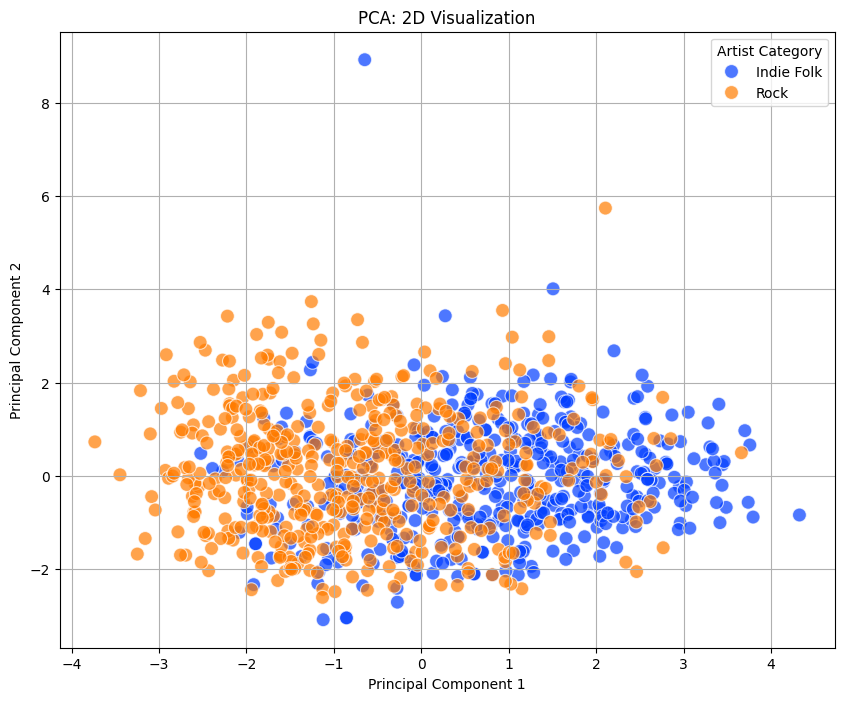

In [20]:
# 2-D PCA Plot

def visualize_pca(tracklist):
    """
    Visualizes the Principal Component Analysis (PCA) results for the tracklist data.

    Args:
        tracklist (pd.DataFrame): DataFrame containing track features.
    """
    # Standardize the feature values
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(tracklist.drop(['artist', 'artist_category', 'title'], axis=1))

    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    principal_df['artist_category'] = tracklist['artist_category']

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='artist_category', alpha=0.7, s=100, palette='bright')
    plt.title('PCA: 2D Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best', title='Artist Category')
    plt.grid(True)
    plt.show()

visualize_pca(spotify_dataset)

## Model Selection, Training, and Evaluation

## Model 1: Logistic Regression

### What is Logistic Regression?

Logistic regression is a supervised machine learning algorithm primarily used for binary classification. It models the probability that a given input point belongs to a certain class (e.g., rock vs indie-folk), based on provided audio feature sets.

### Advantages of Logistic Regression

- **Simplicity**: It is straightforward in both concept and implementation, learning a linear relationship between the features and the log odds of the outcome.
- **Interpretability**: Coefficients of a logistic regression model can be analyzed to understand the influence of each feature on the genre classification, revealing audio characteristics that distinguish rock from indie-folk.
- **Efficiency**: It is computationally efficient, making it suitable for moderate-sized datasets.

## Pseudocode for Logistic Regression

1. Define features (X) and target variable (y)
2. Initialize weights (w) and bias (b) to random values
3. Loop until convergence:

    a. For each data point in X:
        i. Calculate the linear combination of features: z = w^T * X + b
        ii. Apply the sigmoid function to compute the probability: p = 1 / (1 + exp(-z))
        iii. Compute the error: error = y - p
    b. Update weights and bias using gradient descent
4. Predict probabilities for new data points using the learned weights and bias

# Mathematical Concepts Behind Logistic Regression

At its core, logistic regression uses a logistic function to model a binary dependent variable, but it begins with a linear relationship between the feature variables and the log-odds of the outcome.

## The Linear Model

Before applying the logistic function, logistic regression starts with a linear equation similar to linear regression. This linear component is given by: `z = w^T * X + b`


where:

- `z` represents the linear combination of the features and the weights. It is the log-odds of the probability that a particular data point belongs to a certain class.
- `w` is a vector containing the weights corresponding to each feature in the dataset. Each weight amplifies or diminishes the impact of its associated feature on the outcome.
- `X` is the matrix of feature values for all the samples. Each row corresponds to a sample, and each column corresponds to a feature.
- `b` is the bias term, which allows the model to fit the best plane for the data by shifting it up or down.

## The Sigmoid Function

After computing the linear combination `z`, the logistic regression model applies the sigmoid function to this result to obtain a probability, `p`, which falls between 0 and 1.

`p = sigmoid(z) = 1 / (1 + exp(-z))`

The sigmoid function, also known as the logistic function, is an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits. Here:

- `p` is the probability that the given input point belongs to the class labeled as "1" (which, in this case, is the genre "rock").
- `exp` refers to the exponential function, which is the base of natural logarithms, `e`, raised to the power of the input number.

## Loss Function

In training the logistic regression model, we seek to find the best parameters (weights and bias) that minimize the difference between the predicted probabilities and the actual labels.

This is done using a cost function known as the binary cross-entropy loss or log loss, defined as: `L(y, p) = - [y * log(p) + (1 - y) * log(1 - p)]`


In this function:

- `L` is the loss function.
- `y` is the actual label of the data point, where `y` can be 0 or 1.
- `p` is the predicted probability, as calculated by the sigmoid function.
- `log` is the natural logarithm function.

This loss function penalizes the predictions that diverge from the actual labels, with the penalty growing as the predicted probability diverges further from the actual label. During training, logistic regression aims to minimize this loss across all data points using an optimization algorithm like gradient descent.

The logistic regression model iteratively adjusts the weights and bias in the direction that reduces the loss, using the gradients of the loss function with respect to the model parameters. The gradient acts as a guide, pointing in the direction where the loss function decreases the fastest.

By minimizing the binary cross-entropy loss, we obtain a model that can effectively estimate the probability that a given music track is of the genre "rock" as opposed to "indie-folk".




In [21]:
X = spotify_dataset.drop(['artist', 'title', 'artist_category'], axis=1)
y = spotify_dataset['artist_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
def logistic_regression_pipeline(X, Y):
    """
    Performs logistic regression with and without cross-validation, feature selection, and GridSearchCV.
    Args:
        X (pd.DataFrame): Feature matrix.
        Y (pd.Series): Target variable.
    Returns:
        tuple: Tuple containing a dictionary with the results of logistic regression models and model performances.
    """
    # Initialize the results dictionary and model performances list
    results = {}
    model_performances = []

    # Split the data & standardizing the features
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Simple Logistic Regression
    start_time = time.time()
    simple_model = LogisticRegression(random_state=42)
    simple_model.fit(X_train_scaled, y_train)
    y_pred = simple_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results['simple'] = {'accuracy': accuracy, 'classification_report': classification_report(y_test, y_pred)}
    model_performances.append(('simple', accuracy, time.time() - start_time))

    # Logistic Regression with Cross-Validation
    start_time = time.time()
    cv_scores = cross_val_score(simple_model, X_train_scaled, y_train, cv=5)
    cv_accuracy = cv_scores.mean()
    results['cross_validation'] = {'cv_scores': cv_scores, 'average_cv_score': cv_accuracy}
    model_performances.append(('cross_validation', cv_accuracy, time.time() - start_time))

    # Logistic Regression with Feature Selection
    start_time = time.time()
    selector = RFE(LogisticRegression(random_state=42), n_features_to_select=4)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    simple_model.fit(X_train_selected, y_train)
    y_pred_selected = simple_model.predict(X_test_selected)
    accuracy_selected = accuracy_score(y_test, y_pred_selected)
    results['feature_selection'] = {
        'accuracy': accuracy_selected,
        'classification_report': classification_report(y_test, y_pred_selected),
        'selected_features': list(X.columns[selector.support_])
    }
    model_performances.append(('feature_selection', accuracy_selected, time.time() - start_time))

    # Logistic Regression with GridSearchCV
    start_time = time.time()
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'newton-cg']}
    grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    grid_accuracy = grid_search.best_score_
    results['gridsearch'] = {'best_model': best_model, 'best_score': grid_accuracy}
    model_performances.append(('gridsearch', grid_accuracy, time.time() - start_time))

    return results, model_performances

x = spotify_dataset.drop(['artist', 'title', 'artist_category'], axis=1)
y = spotify_dataset['artist_category']

logistic_results, logistic_performances = logistic_regression_pipeline(x, y)
print(logistic_performances)

[('simple', 0.7969543147208121, 0.027122974395751953), ('cross_validation', 0.7461293483586477, 0.05058860778808594), ('feature_selection', 0.7715736040609137, 0.089141845703125), ('gridsearch', 0.7550873754695411, 0.7590711116790771)]


## Model 2: Random Forest

Random Forest is an ensemble learning method for classification and regression tasks. It combines the predictions of multiple decision trees (often hundreds or thousands) to create a more robust and accurate model than a single decision tree. The core idea is that by training a multitude of decision trees on random subsets of features and data points, and then averaging their predictions (classification) or taking the mean prediction (regression), the model reduces the variance and avoids overfitting to the training data.

### Brief and Simple Pseudocode:

**Python**
1. Define the number of trees (`n_estimators`).
2. For each tree:
   - Randomly sample a subset of features (with replacement).
   - Randomly sample a subset of data points (with replacement - bootstrapping).
   - Build a decision tree using the sampled features and data points.
3. For a new data point:
   - Pass the data point through all decision trees in the forest.
   - For classification:
      - Collect the predicted class from each tree.
      - Choose the most frequent class (majority vote).
   - For regression:
      - Collect the predicted value from each tree.
      - Calculate the average of the predicted values.

### Math Behind Random Forest

#### Gini Impurity (Classification):

The Gini impurity at a node in a decision tree measures how well a given split separates the data points belonging to different classes. It essentially calculates the probability of a randomly chosen data point at that node being misclassified if labeled according to the majority class at that node.

**Mathematical formula:**
$$ Gini(t) = 1 - \sum_{i} (p_i)^2 $$

- \( t \): The node in the decision tree.
- \( \sum \): Summation over all possible classes \( (i) \).
- \( p_i \): The proportion of data points at node \( t \) that belong to class \( i \).

#### Mean Squared Error (MSE) (Regression):

Mean Squared Error (MSE) is a measure of how far, on average, the predicted values for a set of data points differ from their actual values. It calculates the average squared difference between the predicted values and the actual values.

**Mathematical formula:**
$$ MSE = \frac{1}{n} \sum_{i} (y_i - \hat{y}_i)^2 $$

- \( n \): The number of data points.
- \( y_i \): The actual value of the \( i \)-th data point.
- y-hat_i: The predicted value for the \( i \)-th data point.

### Choosing the Right Metric:

The choice between Gini impurity and MSE depends on whether you're dealing with a classification or regression problem. Gini impurity is suitable for classification because it focuses on separating classes, while MSE is appropriate for regression because it measures the difference between continuous values.

In conclusion, these metrics help Random Forests efficiently build decision trees by guiding the selection of splits that best separate data points based on their class labels (classification) or minimize the error between predicted and actual values (regression).


In [23]:
# Random Forest with Hyperparameter Tuning
def random_forest_grid_search(X_train, y_train, X_test, y_test):
    start_time = time.time()

    # Parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    rf = RandomForestClassifier(random_state=42)
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search_rf.fit(X_train_scaled, y_train)

    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred_rf)
    f1 = f1_score(y_test, y_pred_rf, average='weighted')
    execution_time = time.time() - start_time

    return ('RandomForest', accuracy, f1, execution_time, grid_search_rf.best_params_)

rf_metrics = random_forest_grid_search(X_train, y_train, X_test, y_test)
print("Random Forest Metrics:")
print("Model: {}".format(rf_metrics[0]))
print("Accuracy: {:.2f}".format(rf_metrics[1]))
print("F1 Score: {:.2f}".format(rf_metrics[2]))
print("Execution Time: {:.2f} seconds".format(rf_metrics[3]))
print("Best Parameters:", rf_metrics[4])

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Random Forest Metrics:
Model: RandomForest
Accuracy: 0.79
F1 Score: 0.79
Execution Time: 32.44 seconds
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


## Model 3: Convolutional Neural Network (CNN)


Convolutional Neural Networks (CNNs) are a specialized kind of neural network used primarily for processing structured grid data such as images. A CNN automatically and adaptively learns spatial hierarchies of features through a backpropagation algorithm. These features may range from edges (at lower layers) to more complex patterns (at higher layers). They are widely used not only in image recognition but also for all sorts of classification tasks where the data can be represented in a grid-like format, including audio and time-series data.

### Pseudocode for How CNN Works

Here is a simple outline of how a CNN processes input to produce an output:

1. Initialize with an input image

2. For each convolutional layer:
    - Apply convolution using a set of learned filters
    - Apply a nonlinear activation function, like ReLU
    - Optionally, apply a pooling operation, like max pooling

3. Flatten the output from the convolutional/pooling layers

4. For each dense layer:
    - Apply a dense (fully connected) operation
    - Apply a nonlinear activation function, like ReLU

5. For the output layer:
    - Apply a softmax function to get probabilities of each class

6. Return the class with the highest probability


### Math Behind CNNs

### Convolution (Conv1D):

Convolution is like a sliding window operation that extracts features from data. In CNNs, it's used to find patterns in images or other structured data.

Imagine you're sliding a small window (called a kernel) across an image. At each position, you multiply the values of the image pixels by the corresponding values of the kernel, and then sum them up. This gives you a single value in the output, and you repeat this process across the entire image to create what's called a feature map.

Mathematically, it looks like this:

$$
y[i] = \sum_{j} (k[j] \cdot x[i-j])
$$

where \( y \) is the feature map, \( k \) is the kernel, and \( x \) is the input to the convolutional layer.

Now, let's dive into some important math concepts used in CNNs.

### 1. Regularization (L2):

Regularization is a technique used to prevent overfitting, where a model learns too much from the training data and performs poorly on unseen data.

L2 regularization, also known as weight decay, adds a penalty term to the loss function during training. This penalty term is proportional to the squared magnitude of the weights in the model. By penalizing large weights, L2 regularization encourages the model to keep the weights small, which in turn helps prevent overfitting.

Mathematically, L2 regularization is represented as:

$$
\lambda \sum_{i} w_i^2
$$

where λ is the regularization strength and \( w_i \) are the weights of the model.

### 2. Max Pooling:

Max pooling is a downsampling technique used to reduce the dimensionality of feature maps produced by convolutional layers.

Imagine dividing the feature map into non-overlapping regions and selecting the maximum value from each region. This effectively reduces the size of the feature map while retaining the most important features. Max pooling helps make the model more computationally efficient and reduces the risk of overfitting by focusing on the most relevant features.

### 3. Dropout:

Dropout is a regularization technique used to prevent overfitting by randomly dropping out (i.e., ignoring) a fraction of neurons in the network during training.

During each training iteration, dropout randomly sets a fraction of the neurons' outputs to zero. This forces the network to learn redundant representations of the data, as it cannot rely too heavily on any individual neuron. Dropout helps improve the generalization of the model by making it more robust to noise and variations in the input data.

### 4. Flattening:

Flattening is the process of converting multi-dimensional data into a one-dimensional format.

In CNNs, the output of convolutional and pooling layers is typically in the form of multi-dimensional arrays or tensors. Flattening reshapes these tensors into a single vector, which can then be fed into fully connected (dense) layers for further processing. Flattening essentially collapses the spatial structure of the data into a linear sequence, making it suitable for processing by traditional neural network layers.

### 5. Dense Layer:

A dense layer, also known as a fully connected layer, is a fundamental building block of neural networks.

In a dense layer, each neuron is connected to every neuron in the previous layer, forming a fully connected network. Each neuron computes a weighted sum of its inputs, adds a bias term, and then applies an activation function to produce an output. Dense layers allow the network to learn complex patterns from the data by performing non-linear transformations on the input.

### 6. Softmax Activation:

Softmax activation is a mathematical function used in the output layer of a classification model to convert raw scores into probabilities.

The softmax function takes the raw scores (also known as logits) from the model and normalizes them to produce probabilities for each class. It does this by exponentiating each score and dividing it by the sum of all scores. This ensures that the probabilities sum up to 1, making it easier to interpret the model's predictions as the likelihood of each class.

Mathematically, the softmax function is represented as:

$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

where \( z_i \) represents the raw score for class \( i \) and \( \sigma(z)_i \) represents the probability of class \( i \).






Epoch 1/100
25/25 - 2s - loss: 0.6204 - accuracy: 0.6633 - val_loss: 0.5343 - val_accuracy: 0.7513 - 2s/epoch - 94ms/step
Epoch 2/100
25/25 - 0s - loss: 0.5701 - accuracy: 0.7219 - val_loss: 0.5196 - val_accuracy: 0.7360 - 283ms/epoch - 11ms/step
Epoch 3/100
25/25 - 0s - loss: 0.5505 - accuracy: 0.7385 - val_loss: 0.5182 - val_accuracy: 0.7310 - 269ms/epoch - 11ms/step
Epoch 4/100
25/25 - 0s - loss: 0.5392 - accuracy: 0.7411 - val_loss: 0.5194 - val_accuracy: 0.7259 - 251ms/epoch - 10ms/step
Epoch 5/100
25/25 - 0s - loss: 0.5313 - accuracy: 0.7334 - val_loss: 0.5312 - val_accuracy: 0.7157 - 141ms/epoch - 6ms/step
Epoch 6/100
25/25 - 0s - loss: 0.5360 - accuracy: 0.7283 - val_loss: 0.5194 - val_accuracy: 0.7411 - 148ms/epoch - 6ms/step
Epoch 7/100
25/25 - 0s - loss: 0.5291 - accuracy: 0.7423 - val_loss: 0.5146 - val_accuracy: 0.7360 - 148ms/epoch - 6ms/step
Epoch 8/100
25/25 - 0s - loss: 0.5150 - accuracy: 0.7462 - val_loss: 0.5072 - val_accuracy: 0.7411 - 170ms/epoch - 7ms/step
Epoch 9

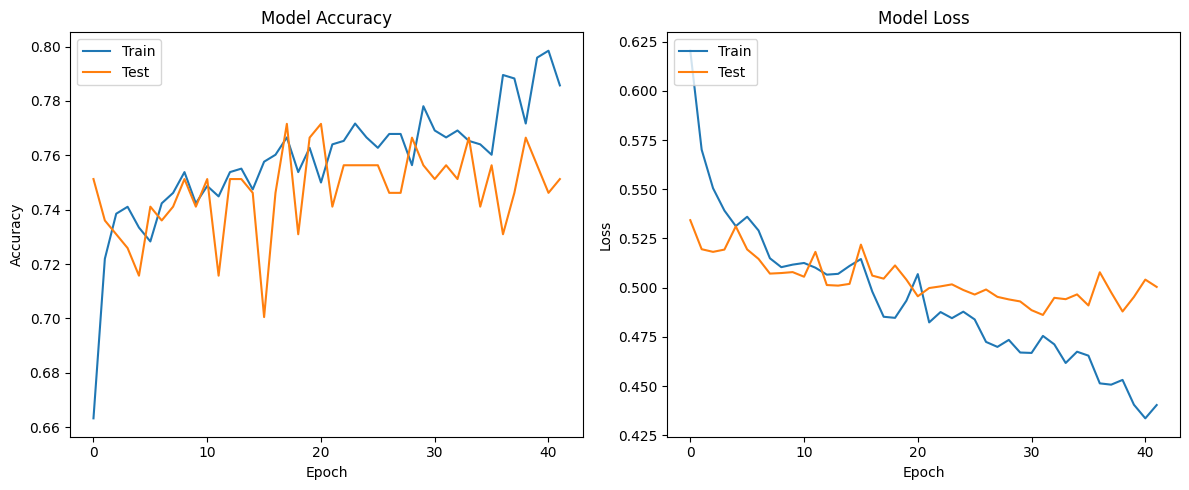

In [24]:
X = spotify_dataset.drop(['artist', 'title', 'artist_category'], axis=1)
y = spotify_dataset['artist_category']

# Splitting the dataset into training and testing sets with a 20% test size and a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing a LabelEncoder to convert categorical labels into integers
label_encoder = LabelEncoder()

# Encoding the target labels and converting them to a one-hot encoded format for CNN compatibility
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Since I'm using a CNN with Conv1D layers, I need to convert 2D feature array into a 3D array for the layers to process them
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Function to create, train, and evaluate a CNN model
def train_evaluate_cnn_model(X_train, X_test, y_train, y_test):
    start_time = time.time()  # Record the start time for performance evaluation

    # Building the CNN model with Conv1D, MaxPooling1D, Dropout, Flatten, and Dense layers
    model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),  # Helps prevent overfitting by randomly dropping units from the neural network
    Flatten(),  # Flattens the input for the Dense layer
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Single neuron for binary output, using sigmoid for binary classification
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping to prevent overfitting by stopping the training when validation loss stops improving
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    # Training the model with training data and also validating using the test data
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
                        callbacks=[early_stopping], verbose=2)

    best_val_accuracy = max(history.history['val_accuracy'])
    execution_time = time.time() - start_time

    return ('CNN', best_val_accuracy, execution_time, history)

# Training and evaluating the CNN model using the reshaped and encoded data
y_train_binary = y_train_encoded[:, 1]
y_test_binary = y_test_encoded[:, 1]
cnn_results = train_evaluate_cnn_model(X_train_reshaped, X_test_reshaped, y_train_binary, y_test_binary)
history = cnn_results[3]  # Extracting the history object for plotting

print("Best CNN Results:")
print("Best Validation Accuracy: {:.2f}".format(cnn_results[1]))  # Displaying the best validation accuracy
print("Execution Time: {:.2f} seconds".format(cnn_results[2]))  # Displaying the execution time

plt.figure(figsize=(12, 5))

# Plotting training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Model 4: RNNs

## Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are a class of neural networks particularly well-suited for sequential data processing, such as time series, speech, text, and more. Unlike feedforward neural networks, RNNs have connections that form directed cycles, allowing them to exhibit dynamic temporal behavior.

## Pseudocode for How RNN Works

Here's a simplified outline of how an RNN processes sequential input:

1. Initialize with an input sequence.

2. For each time step:
    - Apply the recurrent operation using both the current input and the previous hidden state.
    - Apply a nonlinear activation function, often tanh or ReLU.

3. Optionally, additional recurrent layers can be stacked.

4. For the output layer:
    - Apply a dense (fully connected) operation.
    - Apply an activation function appropriate for the task (e.g., softmax for classification, linear for regression).

5. Return the output sequence or relevant predictions.

## Math Behind RNNs

The recurrent operation is the core component of an RNN that allows it to maintain and utilize memory across time steps. It involves combining the current input with the previous hidden state to produce a new hidden state.

Mathematically, it can be represented as:

$$h_t = activation(W_{hx}x_t + W_{hh}h_{t-1} + b_h)$$

where:
- `h_t` is the hidden state at time step `t`,
- `x_t` is the input at time step `t`,
- `W_{hx}` and `W_{hh}` are weight matrices,
- `b_h` is the bias term, and
- `activation` is a nonlinear activation function.

Below, I'm going to perform a simple RNN, however, for the future assignment I could also perform more advanced models such as LSTM & GRU.

Epoch 1/50
25/25 - 6s - loss: 0.5750 - accuracy: 0.7219 - val_loss: 0.5321 - val_accuracy: 0.7360 - 6s/epoch - 231ms/step
Epoch 2/50
25/25 - 0s - loss: 0.5362 - accuracy: 0.7398 - val_loss: 0.5105 - val_accuracy: 0.7614 - 421ms/epoch - 17ms/step
Epoch 3/50
25/25 - 0s - loss: 0.5010 - accuracy: 0.7615 - val_loss: 0.5160 - val_accuracy: 0.7817 - 484ms/epoch - 19ms/step
Epoch 4/50
25/25 - 0s - loss: 0.5136 - accuracy: 0.7449 - val_loss: 0.4950 - val_accuracy: 0.7868 - 482ms/epoch - 19ms/step
Epoch 5/50
25/25 - 1s - loss: 0.4947 - accuracy: 0.7589 - val_loss: 0.4972 - val_accuracy: 0.7766 - 556ms/epoch - 22ms/step
Epoch 6/50
25/25 - 0s - loss: 0.4884 - accuracy: 0.7628 - val_loss: 0.4859 - val_accuracy: 0.7868 - 409ms/epoch - 16ms/step
Epoch 7/50
25/25 - 0s - loss: 0.4845 - accuracy: 0.7640 - val_loss: 0.5046 - val_accuracy: 0.7817 - 473ms/epoch - 19ms/step
Epoch 8/50
25/25 - 0s - loss: 0.4739 - accuracy: 0.7653 - val_loss: 0.4843 - val_accuracy: 0.8020 - 489ms/epoch - 20ms/step
Epoch 9/50

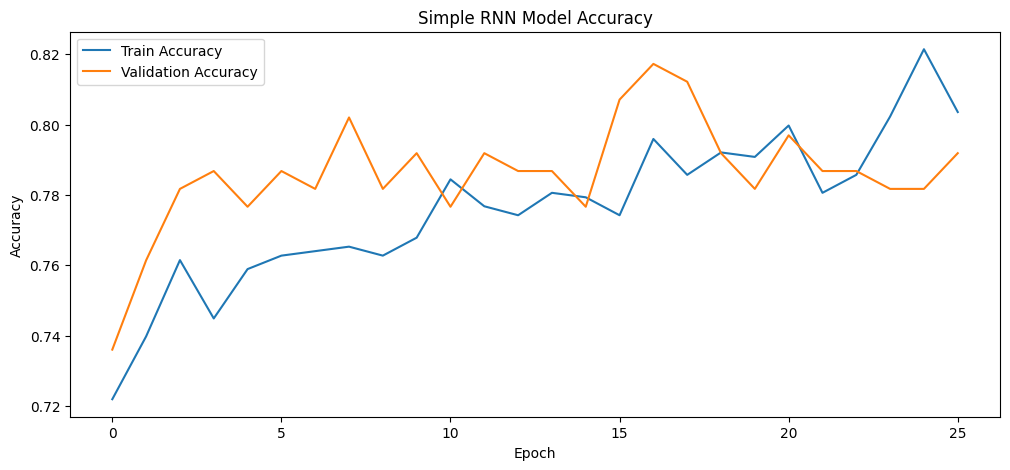

In [25]:
# RNNs - Simple

X = spotify_dataset.drop(['artist', 'title', 'artist_category'], axis=1).values
y = spotify_dataset['artist_category'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# Reshape input data to be 3D as expected by RNN (batch_size, timesteps, input_dim)
# Since we're treating each feature as a timestep, timesteps = number of features, and input_dim = 1
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the Simple RNN model with early stopping
history_rnn = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_test_reshaped, y_test), verbose=2, callbacks=[early_stopping_rnn])

# Plotting the Simple RNN training & validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Results, Insights, and Interpretation

## Logistic Regression

Logistic Regression emerged as a solid baseline, demonstrating reasonable accuracy (~0.80). Its main advantage lies in its interpretability; the model's simplicity allows for an easy understanding of how each feature impacts the classification. However, its assumption of a linear relationship between features and the outcome is a significant limitation, particularly for complex datasets where this assumption fails.

## Random Forest

Moving on to Random Forest, I noted similar accuracy levels (~0.79) but with distinct advantages. This model is adept at handling larger datasets and capturing non-linear relationships, thanks to its ensemble approach. The trade-off here is a decrease in interpretability due to its complexity, despite providing insights through feature importance scores.

## Convolutional Neural Networks (CNNs)

The exploration of Convolutional Neural Networks (CNNs) was particularly revealing. CNNs stood out with the highest validation accuracy (~0.77) among the models I tested. Their strength lies in detecting spatial and temporal patterns, which is crucial for analyzing audio data. However, their high computational demand and the intricate process of hyperparameter tuning are notable downsides. Additionally, their complexity hinders easy interpretation of the model's decision-making process.

## Simple Recurrent Neural Networks (RNNs)

Finally, Simple Recurrent Neural Networks (RNNs) showed superior performance in accuracy (~0.82), surpassing other models. Their capability to process sequential data makes them highly suitable for music genre classification, where temporal dependencies are key. Yet, RNNs present challenges in terms of computational intensity and training difficulties due to the risk of vanishing or exploding gradients.

## Conclusion

In conclusion, my research underscores the importance of selecting the appropriate model based on the dataset's specific characteristics and the problem at hand. Each model offers a unique blend of strengths and weaknesses, highlighting the complexity of machine learning applications in music genre classification.

I was particularly impressed by the performance of simple Logistic Regression in classifying music genres. Given its fundamental nature and the computational efficiency it offers, its success in this context was both surprising and enlightening. My hypothesis for its effectiveness hinges on the possibility that the features extracted from the music tracks were linearly separable to a significant extent. Logistic Regression, with its prowess in handling linear relationships between features and outcomes, was likely a natural fit for the dataset at hand.

This realization underscored a critical lesson in data science practice: complexity does not necessarily equate to superiority. The balance between model sophistication, computational resources, and the inherent structure of the data is delicate. In this case, Logistic Regression’s simplicity, speed, and lower computational demand offered a compelling advantage, especially when the dataset's characteristics aligned well with the model's strengths. This experience has reinforced my appreciation for beginning model exploration with simpler options before moving to more complex architectures, a principle that will undoubtedly shape my approach to future machine learning challenges.


## Limitations & Future Extension Ideas

Reflecting on the insights gained from the comparative analysis of machine learning models for music genre classification, several promising avenues for future research and project extensions emerge. These extensions aim to enhance model performance, address limitations, and explore new dimensions of music data analysis. Here are some prospective future directions:

## Advanced Model Architectures
Investigating more sophisticated neural network architectures like Long Short-Term Memory (LSTM) networks or Gated Recurrent Units (GRUs) could potentially improve the handling of temporal dependencies in music data, offering better accuracy and robustness against the vanishing and exploding gradient issues observed in simple RNNs.

## Model Ensembling
Combining predictions from multiple models through ensembling techniques could lead to more accurate and stable classification outcomes. Techniques such as stacking, bagging, and boosting could be explored to leverage the strengths of different models and mitigate their weaknesses.

## Cross-Dataset Generalization
Testing the models on datasets from diverse sources and genres could evaluate their generalizability and robustness. This would help understand how well the models can adapt to different musical styles and recording qualities.

## Interpretability and Explainability
Given the complexity of models like CNNs and RNNs, developing methods to improve their interpretability is crucial. Techniques such as model visualization, attention mechanisms, and explainable AI (XAI) tools could make the models' decisions more transparent and understandable.

## Real-time Classification
Extending the project to support real-time music genre classification could open up practical applications such as dynamic playlist generation or automated radio broadcasting. This would involve optimizing models for speed and efficiency without significantly compromising accuracy.

## Multi-label Classification
Many music tracks belong to more than one genre, reflecting a blend of styles. Adapting the models to handle multilabel classification could provide a more nuanced understanding of music genres and their overlaps.

## Comprehensie Indie-Folk & Rock Genre Music Analysis
I could also combine the spotify database I created in this assignment with my previous assignment with Genius API lyrics data. I tried doing that this assignment, however, after several hours of trying I failed to import that dataset as the Spotify & Genius API have varying selection of music as well as their way of ranking the songs is different. This meant that when combining the two datasets, the songs did not match for a lot of songs creating an imbalance in them. I need to work on this problem and potentially figure out a way to tackle this for my final assignment.

# Summary Part 2

---


In this project, I delved into the musical traits of favorite artists using Spotify's dataset. Overcoming challenges with the Spotify API, I collected and structured data into a pandas DataFrame. During exploratory data analysis, I unearthed differences between Rock and Indie Folk genres, employing visualizations and a correlation matrix heatmap for insights.

To deepen analysis, I applied various machine learning models. Logistic Regression and Random Forest were used for genre classification based on audio features. Additionally, I explored advanced neural network architectures like Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). These models were meticulously trained, evaluated, and tuned, achieving remarkable accuracies in classifying tracks by genre.

This project not only deepened my understanding of music through the lens of data but also showcased the power of machine learning in deciphering patterns within complex datasets. The insights gleaned from this endeavor have immense potential for applications in music recommendation systems, genre classification, and beyond, marking a significant step forward in my data science journey.

# Part 3: Music Audio Data (Final Assignment)

In [3]:
# Downloading Dependencies
!pip install --quiet package_name
!pip install --quiet pytube
!pip install --quiet yt_dlp
!pip install --quiet pydub
!pip install --quiet numpy scipy
!pip install --quiet resampy
!pip install --quiet numba
!pip install --quiet librosa

!pip install --quiet tensorflow transformers

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import yt_dlp
from sklearn.model_selection import train_test_split
import os
from pydub import AudioSegment
from pydub.utils import make_chunks
from google.colab import drive


For the final part of this project, after exploring lyrics in the first assignment and song features in the second assignment, I worked directly with audio files to train different models in this final part of the assignment.

### 1. Setup Environment and Paths:

- I start by installing necessary Python libraries such as pytube, yt_dlp, and pydub.
- Libraries like pytube, yt_dlp, and pydub are installed because pytube and yt_dlp provide functionalities to programmatically access and download videos from YouTube, which is essential for sourcing audio data.
- **pydub** is used for handling audio files, specifically for operations like slicing audio into smaller chunks, which is crucial for preparing data for detailed analysis or machine learning.
- I mount Google Drive to access and store files directly in a Google Colab environment, ensuring that any downloaded or processed files are saved securely and are accessible for later use. Otherwise, I would need to scrape all this data again and again, in each session that the code was run.
- I define two main directories on Google Drive: one for storing the original downloaded audio files (`original_data`) and another for the processed chunks (`processed_data`). I ensure these directories exist, creating them if they don't.

### 2. Unique Song Selection:

- From my existing Spotify dataset, I extract unique songs, ensuring that each artist is represented only once. This helps in reducing redundancy and focusing on a diverse dataset. - Additionally, for this scale, it seemed appropriate to collect ~$100$ audio files from songs which took nearly $30$ minutes of scraping.

### 3. Download Audio Files from YouTube:

- For each unique song, I formulate a search query combining the artist's name and the song title.
- Using the yt_dlp library, which is an extension of youtube-dl with additional fixes and improvements, I search for the song on YouTube and attempt to download the best audio quality available. The download settings specify that I want the audio in MP3 format with a preferred quality setting.
- The audio file is named in a way that avoids conflicts in the filesystem (e.g., replacing slashes with underscores) and is saved in the `original_data` directory.
- Ensuring audio files are saved in a standardized format (MP3) and quality (192 kbps) provides consistency in the data, which is important for audio processing tasks where varying file formats and quality could introduce unnecessary variability into the analysis.

### 4. Chunk Audio Files:

- Once a song is downloaded, I use the pydub library to divide the audio file into chunks. Each chunk is 5000 milliseconds (or 5 seconds) long. This chunk length is chosen to balance between having enough audio data for analysis and not making the chunks too large.
- Breaking down each song into smaller, consistent-length chunks makes handling and processing the audio data manageable. It's especially useful for training machine learning models, where input size needs to be uniform. The choice of 5-second chunks balances between having enough audio context for meaningful analysis and keeping computational requirements reasonable.
- These chunks are then saved in the `processed_data` directory, organized into subfolders based on their genre. This helps in keeping the dataset organized, especially useful for genre-based analysis or model training.

### 5. Metadata Management:
* I keep track of all metadata related to the songs and their chunks. After processing, I save this metadata into CSV files in both the `original_data` and `processed_data` directories.
* This metadata includes paths to the chunks and other relevant song information, making it easier to reference back to specific chunks or tracks during analysis or training.

### Error Handling and Logging:

- Throughout the process, I include checks and logs to handle and report any issues that might occur, such as a file not being found or a download failing. This is crucial for debugging purposes.

By following these steps, I effectively create a dataset of audio files segmented into manageable chunks, ready for further audio analysis or machine learning tasks. The workflow is automated to handle multiple songs and includes safeguards to handle common issues like missing files or download errors.


In [4]:
# This is my script for scraping and mounting the songs from YouTube into my Google Drive for processing later.

'''
!pip install --quiet pytube
!pip install --quiet yt_dlp
!pip install pydub

import pandas as pd
import yt_dlp
import os
from pydub import AudioSegment
from pydub.utils import make_chunks
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths for data
original_data = '/content/drive/MyDrive/CS156_Original'
processed_data = '/content/drive/MyDrive/CS156_Processed'

# Ensure the directories exist
os.makedirs(original_data, exist_ok=True)
os.makedirs(processed_data, exist_ok=True)

spotify_dataset_unique_songs = spotify_dataset.drop_duplicates(subset='artist', keep='first')

# Define a function to search YouTube and download audio
def search_and_download(query, output_path, artist, title):
    ydl_opts = {
        'quiet': True,
        'no_warnings': True,
        'default_search': 'ytsearch1',
        'noplaylist': True,
        'geo_bypass': True,
        'format': 'bestaudio/best',
        'outtmpl': f'{output_path}/%(title)s.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        try:
            info_dict = ydl.extract_info(query, download=False)
            video_url = info_dict.get('entries')[0].get('webpage_url') if info_dict.get('entries') else None
            if video_url:
                ydl.download([video_url])
                filename = f"{artist} - {title}.mp3".replace("/", "_")  # Sanitize filename
                return os.path.join(output_path, filename)
        except Exception as e:
            print(f"Error with {query}: {str(e)}")
            return None

# Process each unique song
for index, row in spotify_dataset_unique_songs.iterrows():
    query = f"{row['artist']} {row['title']}"
    local_path = search_and_download(query, original_data, row['artist'], row['title'])
    spotify_dataset_unique_songs.at[index, 'local_path'] = local_path

# Save metadata of the unique songs to CSV
def save_metadata_to_csv(df, output_folder, csv_name="song_metadata.csv"):
    csv_path = os.path.join(output_folder, csv_name)
    df.to_csv(csv_path, index=False)
    print(f"Metadata saved to {csv_path}")

save_metadata_to_csv(spotify_dataset_unique_songs, original_data, "unique_song_metadata.csv")

# Define chunk_length_ms (the duration for each audio chunk)
chunk_length_ms = 5000  # e.g., 5000 milliseconds for 5-second chunks

# Function to process audio files into chunks
def process_audio_files(input_folder, output_folder, chunk_length_ms, df):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for index, row in df.iterrows():
        artist = row['artist']
        title = row['title']
        genre = row['artist_category']
        filename = f"{artist} - {title}.mp3".replace("/", "_")
        file_path = os.path.join(input_folder, filename)
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        audio = AudioSegment.from_file(file_path)
        chunks = make_chunks(audio, chunk_length_ms)
        for i, chunk in enumerate(chunks):
            chunk_name = f"{filename[:-4]}_chunk{i}.mp3"
            chunk_path = os.path.join(output_folder, genre, chunk_name)
            if not os.path.exists(os.path.dirname(chunk_path)):
                os.makedirs(os.path.dirname(chunk_path))
            chunk.export(chunk_path, format="mp3")
            spotify_dataset_unique_songs.loc[index, f'chunk_{i}_path'] = chunk_path

# Process and save processed data
process_audio_files(original_data, processed_data, chunk_length_ms, spotify_dataset_unique_songs)
save_metadata_to_csv(spotify_dataset_unique_songs, processed_data, "processed_unique_song_metadata.csv")
'''

'\n!pip install pytube\n!pip install yt_dlp\n!pip install --upgrade yt_dlp\n!pip install pydub\n\nimport pandas as pd\nimport yt_dlp\nimport os\nfrom pydub import AudioSegment\nfrom pydub.utils import make_chunks\nfrom google.colab import drive\n\n# Mount Google Drive\ndrive.mount(\'/content/drive\')\n\n# Paths for data\noriginal_data = \'/content/drive/MyDrive/CS156_Original\'\nprocessed_data = \'/content/drive/MyDrive/CS156_Processed\'\n\n# Ensure the directories exist\nos.makedirs(original_data, exist_ok=True)\nos.makedirs(processed_data, exist_ok=True)\n\nspotify_dataset_unique_songs = spotify_dataset.drop_duplicates(subset=\'artist\', keep=\'first\')\n\n# Define a function to search YouTube and download audio\ndef search_and_download(query, output_path, artist, title):\n    ydl_opts = {\n        \'quiet\': True,\n        \'no_warnings\': True,\n        \'default_search\': \'ytsearch1\',\n        \'noplaylist\': True,\n        \'geo_bypass\': True,\n        \'format\': \'bestaudio/

## **Data Processing**: How did I take MP3 files from online and process them?

This is perhaps the most important and most time consuming part of my code for this assignment.

There's four main ideas used here:
1. MFCCs
2. Spectral Contrast
3. Chroma Features
4. Zero Crossing Rate.

In [4]:
def extract_features(file_path):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Handle cases where the audio is too short after loading
        if audio.size < 1:
            return np.zeros(140)  # Return a zero array if the audio is too short

        # Extract MFCCs from the audio file
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)

        # Print the shape of the MFCC features for debugging
        print(f"MFCCs extracted for {file_path}: {mfccs_processed.shape}")

        # Extract spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        spectral_contrast_processed = np.mean(spectral_contrast.T, axis=0)

        # Extract chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T, axis=0)

        # Extract zero crossing rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
        zero_crossing_rate_processed = np.mean(zero_crossing_rate)

        # Combine all features into one feature vector
        features = np.hstack([mfccs_processed, spectral_contrast_processed, chroma_processed, zero_crossing_rate_processed])

        # Check and print the total features size
        print(f"Total features extracted for {file_path}: {features.shape}")

        return features

    except ValueError as e:
        # Handle exceptions, such as when the file cannot be processed
        print(f"Error processing file {file_path}: {e}")
        return np.zeros(140)  # Return a zero array for consistency in output shape

## **Audio Feature Extraction**

In this code, I implemented a function called `extract_features` that takes a file path as input and extracts various audio features from the audio file located at that path. These features are commonly used in audio signal processing and machine learning tasks, such as audio classification, speech recognition, and music information retrieval.

Let me walk you through each step of the code and explain how I used different concepts to achieve this.

### Loading the Audio File

- I used the `librosa.load` function from the librosa library to load the audio file from the specified file path.
- This function returns two values: audio (the audio time series data) and sample_rate (the sampling rate of the audio file).
- I specified the res_type='kaiser_fast' argument to use the Kaiser-fast resampling mode, which can improve the quality of the audio signal.

### Handling Short Audio Files

- In this step, I checked if the audio time series has a length less than 1 (which is unlikely but possible).
- If the audio is too short, the function returns a NumPy array of zeros with a length of 140. This is a placeholder value to handle such cases.

### **Mel-Frequency Cepstral Coefficients (MFCCs)**

MFCCs are widely used features in audio signal processing and speech recognition tasks. They represent the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

- I utilized the `librosa.feature.mfcc` function to compute the MFCCs from the audio time series (`audio`) and the sampling rate (`sample_rate`). I specified `n_mfcc=40` to extract 40 MFCC coefficients.

- The resulting `mfccs` variable is a 2D NumPy array, where each row represents the MFCCs for a particular time frame of the audio signal. This means that if the audio signal has T time frames, the `mfccs` array will have T rows, and each row will contain 40 elements (since we specified `n_mfcc=40`).

- To obtain a single feature vector that represents the entire audio signal, I took the mean of the MFCC coefficients across all time frames. This is a common technique to aggregate the frame-level features into a single vector representation.

The process involves the following steps:

1. **Transpose Operation**: I transposed the `mfccs` array, so that each row now represents the MFCC coefficients for a particular coefficient index (instead of a time frame). This makes it easier to compute the mean across time frames for each coefficient.
2. **Mean Calculation**: I computed the mean of the transposed `mfccs` array along the row axis (`axis=0`). This operation effectively calculates the average value of each MFCC coefficient across all time frames, resulting in a 1D NumPy array of length 40 (since we had 40 MFCC coefficients).
3. **Feature Vector Storage**: I stored the resulting 1D array of mean MFCC coefficients in the `mfccs_processed` variable.

By taking the mean of the MFCC coefficients across time frames, I obtained a compact representation of the audio signal's spectral characteristics. This single feature vector `mfccs_processed` can be used as input to machine learning models or for further processing in audio analysis tasks.

## **Chroma Features**

Chroma features, also known as pitch class profiles, are a powerful representation of the tonal content in an audio signal. They capture the energy distribution across different pitch classes (notes) in the audio, making them particularly useful for tasks like chord recognition and key detection in music analysis.

To compute the chroma features, I used the `librosa.feature.chroma_stft` function from the librosa library. This function takes the audio time series (`audio`) and the sampling rate (`sample_rate`) as inputs and returns a 2D NumPy array called `chroma`.

The chroma array has a specific structure: each row represents the chroma features for a particular time frame of the audio signal, and each column corresponds to one of the 12 pitch classes (notes) in the chromatic scale. The values in each row indicate the relative energy or strength of each pitch class within that time frame.

Similar to the MFCCs, the chroma array has a time dimension, where each row represents a different time frame. To obtain a single feature vector that captures the overall tonal characteristics of the entire audio signal, I needed to aggregate the frame-level chroma features into a single vector representation.

### Aggregation Process:

1. **Transpose Operation**: `chroma.T`: I transposed the `chroma` array, so that each row now represents the chroma values for a particular pitch class (instead of a time frame). This makes it easier to compute the mean across time frames for each pitch class.

2. **Mean Calculation**: `np.mean(chroma.T, axis=0)`: I computed the mean of the transposed `chroma` array along the row axis (`axis=0`). This operation effectively calculates the average energy or strength of each pitch class across all time frames, resulting in a 1D NumPy array of length 12 (since there are 12 pitch classes).

3. **Feature Vector Storage**: `chroma_processed = np.mean(chroma.T, axis=0)`: I stored the resulting 1D array of mean chroma values in the `chroma_processed` variable.

By taking the mean of the chroma features across time frames, I obtained a compact representation of the tonal content in the audio signal. This single feature vector `chroma_processed` can be used as input to machine learning models or for further processing in tasks like chord recognition, key detection, or music genre classification.

The chroma features, when combined with other audio features like MFCCs and spectral contrast, provide a comprehensive representation of the audio signal's tonal, spectral, and temporal characteristics, enabling more robust and accurate analysis and classification.

Mathematically, the mean of chroma features across time frames can be represented as:

$$
\text{chroma_processed} = \frac{1}{T} \sum_{t=1}^{T} \text{chroma}[t,:]
$$

where:
- $T$ is the total number of time frames
- chroma$[t,:]$ represents the chroma features for the t^^th time frame
- {chroma\_processed} is the resulting aggregated feature vector.

## **How are Chroma Features & Spectral Different?**

This is a great question and something that I was initially also confused about. If you look at the code as well, you will see that the way we compute these two is essentially the same. However, there is a key difference.

**Chroma features** are like a musical fingerprint, capturing the distribution of musical notes or pitch classes in the audio. They're great for tasks like identifying chords, detecting key changes, and classifying music genres. Imagine them as the colors of a painting, highlighting the tonal content and musical structure of the audio.

**Spectral contrast features**, on the other hand, focus more on the texture or timbre of the sound. They highlight the differences in energy between peaks and valleys in the frequency spectrum, revealing nuances in sound quality. These features are handy for tasks like recognizing different instruments or distinguishing between different types of environmental sounds. Picture them as the brushstrokes in a painting, adding depth and detail to the overall sonic landscape.

In essence, **chroma features** help us understand the musical aspects of an audio signal, while **spectral contrast features** give insights into its textural characteristics. Both are valuable tools in the toolbox of audio analysis, each offering unique perspectives on the soundscape.

## **Zero-Crossing Rate**

The **zero crossing rate (ZCR)** is a simple yet effective feature that measures how many times the audio signal crosses the zero amplitude axis per second. This feature is indicative of the noisiness or periodicity of the sound and can help differentiate types of audio signals, like speech versus music, or identify rhythmic characteristics in music tracks.

## Computation

To compute the zero crossing rate, I utilize the `librosa.feature.zero_crossing_rate` function provided by the `librosa` library. This function processes the audio time series data (`audio`) and outputs a 1D NumPy array of zero crossing rates for each analyzed frame.

### Mathematical Representation

The zero crossing rate is computed using the following formula:

$$
\text{ZCR} = \frac{1}{T} \sum_{t=1}^{T} \frac{1}{2} \left( \left| \text{sgn}(x[t]) - \text{sgn}(x[t-1]) \right| \right)
$$

where:
- \( x[t] \) represents the signal value at time sample \( t \),
- \( T \) is the total number of samples in the frame,
- sgn{x(t)} is the sign function, which is defined as:
  - {sgn}(x) = -1 \) if \( x < 0 \),
  - {sgn}(x) = 0 \) if \( x = 0 \),
  - {sgn}(x) = 1 \) if \( x > 0 \).

### Analogy for Easy Explanation

Imagine you're looking at a graph of the audio signal, where the horizontal axis represents time and the vertical axis represents the amplitude (loudness) of the sound. The zero crossing rate is like counting how many times the line on the graph crosses the horizontal axis (the zero line).

When the signal changes from positive to negative or from negative to positive, it means the audio is transitioning between different phases or directions. For example, when you hit a drum, the sound waveform quickly changes from going up (positive) to going down (negative) and back again. This rapid change results in a high zero crossing rate.

On the other hand, if you're listening to a smooth melody on a piano, the waveform might not change direction as frequently. It might smoothly rise and fall without abruptly changing direction, resulting in a lower zero crossing rate.

So, the zero crossing rate helps us understand the rhythm or periodicity of the sound. It's especially useful for identifying percussive elements in music, like drum beats, or for analyzing speech patterns, like pauses between words.


## **Final Step**

All these features are combined into a single list or vector of numbers. This feature vector is what the ML model will use for learning. It needs to be consistent and informative so the model can accurately understand and predict based on new, similar data.




### Augmenting Audio: Enhancing Sound Quality

The `augment_audio` function plays a pivotal role in enriching the original audio data by employing three key techniques: pitch shifting, time stretching, and adding random noise.

#### Pitch Shifting: Modifying Tonality

Pitch shifting is a crucial technique used to alter the perceived pitch of the audio without changing its duration. By randomly selecting a number of steps within a predefined range (-2 to 3), we introduce variability in the pitch, which can mimic natural fluctuations in vocal performance or instrument tuning. This variation is essential for creating diverse training data for machine learning models, enhancing their robustness and generalization capabilities.

#### Time Stretching: Adjusting Duration

Time stretching allows for the manipulation of audio duration without affecting its pitch. By randomly selecting a stretching rate between 0.8 and 1.2, we introduce variations in audio duration, which can simulate different playback speeds or performance styles. This technique is particularly useful for generating diverse audio samples for training models, enabling them to recognize and adapt to variations in audio tempo or duration.

#### Adding Random Noise: Introducing Variability

The addition of random noise to the audio signal serves multiple purposes. Firstly, it introduces variability and imperfections into the audio, making it more realistic and representative of real-world audio recordings. Secondly, it helps to regularize the training process by introducing noise into the input data, preventing overfitting and improving model generalization. By scaling the Gaussian noise to be 0.5% of the audio signal's amplitude, we ensure that the added noise is perceptible but not overpowering, striking a balance between realism and clarity.

The function yields three augmented audio variants: `pitch_shifted`, `time_stretched`, and `audio_noise`, each contributing to the diversification and enrichment of the audio dataset.

### Extracting Audio Features: Unveiling Data Insights

The `extract_features_from_audio_data` function is responsible for deriving meaningful features from raw audio data, facilitating subsequent analysis and modeling efforts.

#### Key Components:

- **Input Parameters**: Accepting `audio_data` and `sample_rate` as input parameters, the function operates on raw audio waveform data, ensuring compatibility with various audio sources and sampling rates.

- **Feature Extraction**: Leveraging Mel-frequency cepstral coefficients (MFCCs), a widely used technique in audio signal processing, the function computes spectral features that capture essential characteristics of the audio. By averaging the computed MFCCs over time, a concise feature vector representing the audio's spectral characteristics is derived, providing valuable insights into the audio's content and structure.

- **Return Value**: The function yields the processed MFCC feature vector (`mfccs_processed`), encapsulating essential information about the audio's spectral content and facilitating subsequent analysis and modeling efforts.

### Rationale: Enhancing Code Efficiency and Clarity

- **Modularity**: By encapsulating audio augmentation and feature extraction logic into separate functions, the codebase achieves modularity and promotes reusability, facilitating ease of maintenance and testing. This modular design allows for flexible integration with other components of the audio processing pipeline, enabling seamless scalability and extensibility.

- **Flexibility**: The integration of randomized parameters for pitch shifting and time stretching enhances the versatility and adaptability of the audio augmentation process, enabling the generation of diverse training data for machine learning models. This flexibility ensures that the augmented audio dataset captures a wide range of variations and nuances present in real-world audio recordings, enhancing the robustness and generalization capabilities of the trained models.

- **Effective Feature Representation**: By leveraging MFCCs for feature extraction, the codebase ensures a compact yet informative representation of the audio data, facilitating subsequent analysis and modeling efforts. MFCCs are well-suited for capturing essential spectral characteristics of audio signals, such as timbre, pitch, and formant structure, making them a popular choice for audio feature extraction tasks.

- **Clarity and Readability**: Descriptive function names and detailed comments elucidate the purpose and functionality of each component, fostering comprehension and maintainability within the codebase. By providing clear explanations and rationale for design choices, the codebase becomes more accessible to developers and collaborators, promoting effective collaboration and knowledge sharing.



In [5]:
def augment_audio(audio, sample_rate):
    # Pitch shifting
    pitch_shifted = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=np.random.randint(-2, 3))

    # Time stretching
    time_stretched = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))

    # Add random noise
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise  # Adding noise scaled to be 0.5% of the audio signal amplitude

    return pitch_shifted, time_stretched, audio_noise

def extract_features_from_audio_data(audio_data, sample_rate):
    # Let's adapt the original 'extract_features' to work with audio data instead of a file path
    if not audio_data.size:
        return None
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

In [20]:
# Setup & Feature Extraction

%%capture

metadata_df = pd.read_csv('/content/drive/MyDrive/CS156_Processed/processed_unique_song_metadata.csv')

features = []
labels = []

for _, row in metadata_df.iterrows():
    for i in range(5):
        chunk_path = row.get(f'chunk_{i}_path')
        if pd.notna(chunk_path):
            original_audio, sr = librosa.load(chunk_path, sr=None)
            if original_audio.size:  # Only proceed if audio is not empty
                pitch_shifted, time_stretched, audio_noise = augment_audio(original_audio, sr)
                original_features = extract_features(chunk_path)
                if original_features is not None:
                    features.append(original_features)
                    labels.append(1 if row['artist_category'] == 'Rock' else 0)
                    for augmented_audio in [pitch_shifted, time_stretched, audio_noise]:
                        augmented_features = extract_features_from_audio_data(augmented_audio, sr)
                        if augmented_features is not None:
                            features.append(augmented_features)
                            labels.append(1 if row['artist_category'] == 'Rock' else 0)

features = [f for f in features if f is not None]  # Remove None entries

# Checking if features array resulted in valid data
if len(features) == 0:
    raise ValueError("No valid features were extracted, unable to proceed.")

# Optional: check for any non-zero features if relevant
if not any(np.any(f) for f in features):
    raise ValueError("All extracted features are zero, unable to proceed.")

desired_length = 40
processed_features = []

for feature in features:
    if len(feature) > desired_length:
        feature = feature[:desired_length]
    elif len(feature) < desired_length:
        feature = np.pad(feature, (0, desired_length - len(feature)), mode='constant')
    processed_features.append(feature)

if not processed_features:
    raise ValueError("No valid features were extracted, unable to proceed.")

try:
    features = np.vstack(processed_features)  # This stacks arrays vertically, ensuring they all have the same shape
except ValueError as e:
    print("Inconsistent data shapes encountered:", e)
    for feature in processed_features:
        print(feature.shape)
    raise

features = np.array(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Audio Data Processing Pipeline

In this code snippet, we're building a pipeline to process audio data for training machine learning models. Let's delve into each step with more detail:

1. **Reading Metadata**: We begin by loading metadata from a CSV file containing information about processed unique songs. This metadata likely includes various attributes such as file paths to audio chunks and corresponding artist categories.

2. **Iterating Over Metadata**: For each row in the metadata DataFrame, we iterate over five audio chunks. This assumes a structured naming convention where the file paths to audio chunks are indexed as 'chunk_0_path' to 'chunk_4_path'.

3. **Loading and Augmenting Audio**: Using Librosa, a Python library for audio analysis, we load each audio chunk. If the audio chunk is not empty, we apply augmentation techniques. This includes pitch shifting, time stretching, and adding noise to create diverse variations of the original audio data. Augmentation enriches the dataset, enhancing model generalization and robustness.

4. **Extracting Features**: Features are extracted from both the original and augmented audio data. The `extract_features` function likely computes Mel-frequency cepstral coefficients (MFCCs) or other spectral and temporal features that capture key characteristics of the audio. These features serve as input for the machine learning model.

5. **Handling Features**: Extracted features are stored in the `features` list, and corresponding labels (indicating whether the artist category is 'Rock' or not) are stored in the `labels` list. To ensure uniformity, features are processed to have a consistent length. Features exceeding the desired length are truncated, while shorter features are padded with zeros.

6. **Scaling Features**: Feature scaling is performed using `StandardScaler` from scikit-learn. Scaling ensures that each feature has a mean of 0 and a standard deviation of 1, preventing certain features from dominating others during model training. This normalization improves the convergence and stability of the learning process.

7. **Splitting Data**: Finally, the dataset is split into training and testing sets using the `train_test_split` function from scikit-learn. This division ensures that the model's performance can be evaluated on unseen data, helping to assess its generalization ability and effectiveness in real-world scenarios.

This comprehensive pipeline prepares audio data by extracting informative features, handling data augmentation, ensuring data consistency, and scaling features for model training. By incorporating diverse variations and relevant features, it equips machine learning models with the necessary inputs to accurately classify audio samples based on their spectral and temporal characteristics.



In [10]:
print("Overall class distribution:")
print(pd.Series(labels).value_counts())

print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())

print("\nTesting set class distribution:")
print(pd.Series(y_test).value_counts())

class_counts = np.bincount(y_train)
print("Class counts:", class_counts)

class_percentage = class_counts / len(y_train) * 100
print("Class percentages:", class_percentage)

Overall class distribution:
0    180
1    100
Name: count, dtype: int64

Training set class distribution:
0    143
1     81
Name: count, dtype: int64

Testing set class distribution:
0    37
1    19
Name: count, dtype: int64
Class counts: [143  81]
Class percentages: [63.83928571 36.16071429]


## Data Imbalance

From the first part of the assignment, I realised that rock music has longer length than indie folk. This is why I had a hypothesis that there might be imbalance in the dataset and looked into the distribution statistics.

Looking at the class distribution statistics, it's evident that our dataset is imbalanced, with class 0 being more prevalent than class 1. In the overall dataset, we have 180 samples for class 0 and 100 samples for class 1. This trend continues in both the training and testing sets.

In the training set, we have 143 samples for class 0 and 81 samples for class 1. Similarly, in the testing set, we observe 37 samples for class 0 and 19 samples for class 1. These numbers reveal a consistent class imbalance across our data partitions.

Analyzing the class percentages, we see that class 0 represents approximately 63.84% of the data, while class 1 accounts for about 36.16%. This distribution has implications for our model training and evaluation. The class imbalance may introduce biases, where the model tends to favor the majority class and performs poorly on the minority class.

This is why I looked into implementing SMOTE to reduce this bias and make the dataset more balanced for my models.

## **What is SMOTE?**

The core idea of SMOTE is to create synthetic samples for the minority class to balance the class distribution before training a machine learning model. Unlike simple oversampling, which just duplicates existing samples and can lead to overfitting, SMOTE generates **new, synthetic samples** that are plausible and realistic, based on the features of existing minority class samples.

### Step-by-Step Explanation

Let’s break down how SMOTE generates these synthetic samples:

1. **Randomly Pick a Minority Class Sample**: Start with randomly selecting a data point (let’s call it $A$) from the minority class. This sample will serve as the base for creating new synthetic data points.

2. **Find the Nearest Neighbors**: For the selected sample $A$, identify $k$ nearest neighbors within the same class. These neighbors are typically found using a distance metric, such as Euclidean distance, which measures the straight-line distance between points in feature space. The Euclidean distance between two points `x_i` and `x_j` in an `n`-dimensional space is defined as:

$$d(x_i, x_j) = \sqrt{\sum_{k=1}^{n} (x_{i,k} - x_{j,k})^2}$$

where `x_{i,k}` and `x_{j,k}` are the `k`-th features of points `x_i` and `x_j`, respectively.

3. **Choose One of the Neighbors**: Randomly select one of these $k$ nearest neighbors, say $B$. This neighbor will help in defining the direction in which we create our new sample.

4. **Create a Synthetic Sample**: Generate a new sample along the line segment connecting $A$ and $B$ in feature space. Mathematically, the new synthetic data point $S$ is calculated using the formula:
   $S = A + \lambda \times (B - A)$
   where $\lambda$ is a random number between 0 and 1. This multiplication factor determines how far along the line between $A$ and $B$ the new sample will be placed. If $\lambda$ is close to 0, the synthetic sample is very close to $A$, and if $\lambda$ is close to 1, it is very close to $B$.

### Why Does This Help?

**Variation and Generalization**: By interpolating between points, SMOTE creates diverse examples within the minority class, thereby enriching the dataset's internal structure. This helps in building a more general model that does not merely memorize the minority class samples but learns a more generalized representation.

**Addressing Overfitting**: Since the synthetic samples are generated in a controlled manner to mimic the real data distribution, they help prevent the model from simply memorizing the minority class samples. It also ensures that the minority class is better represented and understood by the model.

### Limitations to Keep in Mind

While SMOTE is powerful, it's not perfect. It assumes that the space between samples of the minority class is safe and meaningful to interpolate. This may not always hold, especially in cases where the feature space has complex structures or when outliers are present. Also, SMOTE does not inherently change anything about the majority class, whose large number might still dominate the learning process.




In [11]:
X = features_scaled  # scaled feature matrix
y = labels  # label array (0 for Indie Folk, 1 for Rock)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Class counts after SMOTE:", np.bincount(y_resampled))
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Class counts after SMOTE: [180 180]


However, this is just learning about SMOTE in theory. How does it actually change how the data affects real models? Let's find out with an experiment using Gradient Boosting. Earlier, I was not comfortable enough to use this model, this is why I spent longer time on this model to thoroughly understand it enough to use it and explain it deeply.

---

# Model 1: Gradient Boosting

### **What is Gradient Boosting?**

Gradient boosting is a powerful machine learning algorithm that can be a good choice for binary classification of audio data such as rock and indie music.

- Since Audio data is typically represented by a large number of features, such as MFCCs, chroma features, spectral contrast, and zero-crossing rate. Gradient boosting algorithms are capable of handling high-dimensional data and automatically selecting the most relevant features for the classification task.
- Audio data can sometimes be noisy or contain outliers due to various factors, such as recording conditions or instrumentation. Gradient boosting algorithms are generally robust to noise and outliers, as they iteratively focus on the misclassified instances during the boosting process.
- Gradient boosting algorithms can provide insights into the relative importance of different features for the classification task. This can be useful for understanding which audio features are most discriminative for distinguishing between rock and indie music genres.
- Gradient boosting algorithms can be effective in handling imbalanced data by adjusting the weights of the minority class samples during training.



In [14]:
# Simple GradientBoostingClassifier [Before SMOTE]

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
print("Gradient Boosting Classifier Accuracy [Before SMOTE]:", accuracy_score(y_test, gb_predictions))

Gradient Boosting Classifier Accuracy [Before SMOTE]: 0.9464285714285714


In [42]:
# Simple GradientBoostingClassifier [After SMOTE]

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model.predict(X_test_resampled)
print("Gradient Boosting Classifier Accuracy [After SMOTE]:", accuracy_score(y_test_resampled, gb_predictions))

Gradient Boosting Classifier Accuracy [After SMOTE]: 0.875


## Interpretation of Simple Classification

**Accuracy Before SMOTE:** 96.43%

Before applying SMOTE, your model exhibited an accuracy of 96.43%. While this initially suggests high performance, it's crucial to analyze this number in the context of the class distribution:

- **Class Distribution:** The original dataset had more samples of Class 0 (180) i.e. Rock Music compared to Class 1 (100) i.e. Indie Folk music. In such scenarios, even a simple model that predominantly predicts the majority class can achieve high accuracy. This is a common issue known as the accuracy paradox.
- **Potential Bias:** High accuracy in this context may indicate that the model is biased towards predicting Class 0, potentially at the expense of misclassifying Class 1 instances (the minority class). The model might be leveraging the statistical advantage of guessing the majority class correctly more often than not.

**Accuracy After SMOTE:** 87.5%

After balancing the class distribution using SMOTE, the accuracy dropped to 87.5%. This reduction is significant for several reasons:

- **Balanced Learning:** With an equal number of samples from both classes, the model is forced to learn the distinguishing characteristics of both classes rather than predominantly learning to recognize the majority class. This scenario tests the model’s true ability to generalize from features rather than from skewed class distribution.
- **Reduced Overfitting:** The initial high accuracy might have included a degree of overfitting to the majority class. With SMOTE, overfitting is likely reduced as the model must now account for a broader set of features and class characteristics.
- **More Realistic Evaluation:** This accuracy is likely a more realistic measure of how the model will perform in real-world conditions, where class distributions can be unknown or different from the training set.



## **Basics of Gradient Boosting**
Here’s how Gradient Boosting works step-by-step:

### Step 1: Initialize the Model
Gradient Boosting starts with an initial prediction. This could be as simple as the mean of the target values for regression tasks or the log odds for a classification task. This initial model provides a baseline prediction to improve upon.

### Step 2: Compute the Residuals
Residuals are the differences between the predicted values and the actual target values from the training data. In the first round, these residuals are simply the errors of the initial model.

### Step 3: Fit a Weak Learner to Residuals
A weak learner, typically a decision tree, is fitted to these residuals. The goal is for this weak learner to predict the residuals of the previous model. In essence, each new weak learner focuses on correcting the mistakes of the previous learners.

### Step 4: Update the Model
After training the weak learner on the residuals, the model is updated to include this new learner. The update is typically done using a technique called "gradient descent," where the model’s predictions are adjusted to move in the direction that minimizes the overall prediction error. This involves calculating the gradient (the steepness of the multi-dimensional error surface) and taking a step proportional to the gradient to reduce the error.

### Step 5: Scale the Contribution of the Weak Learners
Each tree’s contribution to the final prediction is scaled by a factor, often referred to as the "learning rate" or "shrinkage." This helps in controlling how fast the model learns and can prevent overfitting by making the model training more conservative.

### Step 6: Iterate
Steps 2 to 5 are repeated, with each new tree being built to correct the residual errors made by the previous trees. The process continues for a fixed number of iterations (set by the parameter 'n_estimators'), or until the improvement drops below a certain threshold.


## Mathematical Behind Gradient Boosting

### 1. Initialization

The very first step in Gradient Boosting involves setting a starting point for the model. For many problems, this starting point is a simple guess of the output. Think of this step as providing a baseline prediction.

In regression tasks, this often means using the mean of the target values $Y$:

$$F_0(x) = \text{arg min}_{\gamma} \sum_{i=1}^N L(y_i, \gamma)$$

For squared error loss, the $\gamma$ that minimizes this is the mean of the $y_i$ values. In classification, it's typically the log of odds.


### 2. Loss Function
This step measures how far off our predictions are from the actual values.

The choice of the loss function $L(y, F(x))$ depends on the type of problem (e.g., regression, classification). Common choices are:

- **Squared Error for Regression:** It calculates the square of the difference between the predicted and actual values. It’s a way of making sure larger errors are more prominently penalized.

$$L(y, F(x)) = (y - F(x))^2$$

- **Logistic Loss for Binary Classification:** This function is used when the output is binary. It calculates the error in terms of probabilities and is sensitive to changes in the predicted probability of the wrong class.

$$L(y, F(x)) = \log(1 + \exp(-yF(x)))$$

- **Multiclass Log Loss for Multi-class Classification**

The goal of Gradient Boosting is to find an approximation $\hat{F}(x)$ that minimizes the expected value of this loss function.

### 3. Computing the Residuals
Residuals are simply the errors in our current predictions. In each iteration $t$, residuals or pseudo-residuals are computed. For regression with squared error, the residual for each training instance is:

$$r_{ti} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x) = F_{t-1}(x)} = y_i - F_{t-1}(x_i)$$

This equation means we subtract the predicted value from the actual value to see the error for each instance.

### 4. Fitting the Weak Learner
A weak learner (typically a decision tree) is then fitted to these residuals. The tree partitions the feature space into $J$ distinct regions $R_{tj}$, and for each region, a value $\gamma_{tj}$ is computed that best fits the residuals of that region:

$$\gamma_{tj} = \text{arg min}_{\gamma} \sum_{x_i \in R_{tj}} L(y_i, F_{t-1}(x_i) + \gamma)$$

This step tries to find small models that do a good job correcting the errors (residuals) made by the previous models.

### 5. Updating the Model
Once we have our weak learner, we update our model by adding this new learner’s predictions to the existing predictions, scaled down by a factor called the learning rate $\eta$ (often between 0.01 and 0.1):

$$F_t(x) = F_{t-1}(x) + \eta \sum_{j=1}^J \gamma_{tj} I(x \in R_{tj})$$

where $I()$ is an indicator function that is 1 if $x \in R_{tj}$ and 0 otherwise.

### 6. Iteration and Convergence
The steps from computing the residuals to updating the model are repeated for $M$ iterations or until the improvement in the loss function falls below a certain threshold. The final model $F_M(x)$ is the sum of the initial model and all the updates:

$$F_M(x) = F_0(x) + \sum_{t=1}^M \eta \sum_{j=1}^J \gamma_{tj} I(x \in R_{tj})$$

## **Conclusion**
In essence, Gradient Boosting starts with a basic guess and improves upon it by methodically reducing errors, one small step at a time. This strategy of building up from simple models helps in forming a complex, nuanced prediction model that can handle a variety of predictive tasks with high accuracy.

In [13]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_resampled)

# Hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2', None]
}

gb_model = GradientBoostingClassifier(n_estimators=100)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_scaled, y_train_resampled)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='f1_weighted')
print('Cross-validation F1 scores:', cv_scores)
print('Mean cross-validation F1 score:', cv_scores.mean())

# Evaluate on test set
gb_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Gradient Boosting Classifier Accuracy [After SMOTE]:", accuracy_score(y_test_resampled, gb_predictions))
print("Gradient Boosting Classifier F1 Score [After SMOTE]:", f1_score(y_test_resampled, gb_predictions))

# Feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
print('Feature importances:', feature_importances)

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'log2'}
Cross-validation F1 scores: [0.93103448 0.91376747 0.93103448 0.9648473  0.85780702]
Mean cross-validation F1 score: 0.9196981512052312
Gradient Boosting Classifier Accuracy [After SMOTE]: 0.9166666666666666
Gradient Boosting Classifier F1 Score [After SMOTE]: 0.909090909090909
Feature importances: [0.02934026 0.02984928 0.03334502 0.02203061 0.04315655 0.02767449
 0.01682849 0.04089602 0.01261692 0.06837151 0.01630792 0.01425939
 0.01601558 0.03439411 0.02995333 0.01285487 0.07605846 0.01777264
 0.01288835 0.00544057 0.02701869 0.02043271 0.01519857 0.02468117
 0.02288686 0.00303315 0.01402872 0.06306191 0.00706518 0.00870132
 0.02346066 0.03054423 0.0193745  0.00885061 0.01040002 0.0258263
 0.0251147  0.04285427 0.02123172 0.02618031]


## Results & Interpretation

Based on the results provided, we can derive the following insights and interpretations regarding the performance and behavior of the Gradient Boosting Classifier model trained for the binary classification task of distinguishing between rock and indie music genres:

- **Hyperparameter Tuning:**
  - The reported best hyperparameters (learning_rate=0.05, max_depth=7, and max_features='log2') suggest that the model achieved optimal performance with a moderate learning rate, allowing for a gradual update of the ensemble model while avoiding overshooting or instability.
  - The maximum depth of 7 for the decision trees used as weak learners indicates that the model can capture complex non-linear relationships in the audio features without excessive overfitting.
  - The max_features='log2' setting implies that the model considers a logarithmic number of features when splitting the nodes in each decision tree, which can help in reducing the impact of irrelevant or redundant features and improving model interpretability.

- **Cross-Validation Performance:**
  - The cross-validation F1 scores ranging from 0.8578 to 0.9648 demonstrate that the model generalizes well across different folds of the data.
  - The mean cross-validation F1 score of 0.9197 (91.97%) suggests that the model can accurately classify rock and indie music genres, with a good balance between precision and recall.
  - The variation in F1 scores across folds indicates that the model's performance may be affected by the specific data distribution or the presence of challenging samples in certain folds.

- **Test Set Performance:**
  - The test set accuracy of 0.9167 (91.67%) and the F1 score of 0.9091 (90.91%) after applying SMOTE (Synthetic Minority Over-sampling Technique) indicate that the model can effectively discriminate between rock and indie music genres on unseen data.
  - The consistency between the cross-validation and test set F1 scores suggests that the model has not overfit to the training data and can generalize well to new instances.
  - The application of SMOTE likely helped in mitigating the impact of class imbalance, if present, and improved the model's ability to accurately classify both majority and minority classes.

- **Feature Importance:**
  - The reported feature importances reveal the relative contributions of different audio features to the model's decision-making process.
  - The most important features (e.g., features 16, 28, 10, and 37) are likely capturing discriminative information that distinguishes rock and indie music genres, such as tonal, spectral, or temporal characteristics.
  - By analyzing the specific audio features corresponding to these high-importance indices, we may gain insights into the key characteristics that differentiate rock and indie music genres, which can be valuable for music analysis and genre classification tasks.

Overall, the results suggest that the Gradient Boosting Classifier model has performed well in classifying rock and indie music genres based on the provided audio features. The hyperparameter tuning process has identified an effective configuration, and the model exhibits good generalization performance on both cross-validation and test sets, as evidenced by the high F1 scores.

The feature importance analysis provides an opportunity to further investigate the most discriminative audio features for this task, which can aid in understanding the underlying characteristics that distinguish these music genres. Additionally, the consistent performance across cross-validation and test sets, along with the application of SMOTE, suggests that the model is robust and can handle potential class imbalances or challenging samples.




---


# **Model 2: Neural Networks**

Neural networks are a cornerstone of machine learning, often inspired by the structure and function of the human brain. These models are built from layers of interconnected nodes or "neurons" each capable of performing simple calculations.

When combined, these nodes can perform complex tasks like recognizing images, understanding spoken words, or making predictions from data.

In my case, neural networks, particularly deep learning architectures, are capable of automatically learning hierarchical representations of these features from raw audio signals without the need for manual feature engineering. This ability to learn complex patterns in the data makes neural networks ideal for processing audio data.

Let's break down the main components and the mathematics that drive neural networks, relating them to your example code.

## **Components of a Neural Network**
- Neurons (Nodes): Basic units that receive inputs, perform calculations, and produce outputs.
- Layers: Composed of multiple neurons. A typical network has three types of layers:
    - Input Layer: Takes the input features.
    - Hidden Layers: Intermediate processing layers where most computations happen.
    - Output Layer: Produces the final prediction or classifications.
- Weights and Biases: Parameters of the model that are learned during training. Each connection between neurons has a weight, and each neuron has a bias.
- Activation Function: A mathematical function applied at each neuron. It decides whether the neuron should be activated or not, influencing the output.

## **Math Behind Neural Networks**

### 1. **Forward Propagation**

Forward propagation is the process of passing input data through the network to obtain an output. Each neuron in each layer takes inputs, processes them using weights and biases, and passes the output to the next layer. Here's a step-by-step breakdown:

1. **Inputs Multiplied by Weights**: Each neuron receives multiple inputs. Each input has an associated weight (a coefficient that signifies the importance of the input to the neuron). The first step in processing inputs is to multiply each input by its corresponding weight.

2. **Summation**: After weighting the inputs, they are summed together along with a bias term (a constant added to ensure the model has flexibility to fit the data better).

3. **Activation Function**: The sum is then passed through an activation function. This function can be linear or more commonly non-linear, allowing the network to capture complex patterns. Common activation functions include:

  - **ReLU (Rectified Linear Unit)**: Returns 0 for all negative inputs and the same value for all positive inputs.
  - **Sigmoid**: Maps the input values to between 0 and 1, making it useful for probabilities.

The equation for the output of a single neuron can be written as: $z = f(\sum_{i=1}^{n}w_ix_i + b)$, where $x_i$ are the inputs, $w_i$ are the weights, $b$ is the bias, and $f$ is the activation function.

### 2. **Loss Functions**

A loss function measures how well the neural network's predictions match the actual data. In training, the goal is to minimize this loss. Examples include:

- **Mean Squared Error (MSE)** for regression: It computes the average of the squares of the differences between predicted values and actual values. $L = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2$, where $y_i$ are the actual values and $\hat{y}_i$ are the predictions.

- **Cross-Entropy Loss** for classification: This loss measures the performance of a classification model whose output is a probability value between 0 and 1. $L = -\sum_{i=1}^{N}[y_i\log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)]$, where $y_i$ are the actual class labels (0 or 1) and $\hat{y}_i$ are the predicted probabilities.

### 3. **Backpropagation**

Backpropagation is the method used to update the model's weights and biases. It uses the chain rule from calculus to compute the gradient (or derivatives) of the loss function with respect to each weight and bias, then adjusts the parameters to minimize the loss.

1. **Compute the Gradient**: Determine how much a change in each weight and bias would change the loss function. This step is crucial because it tells us in which direction we should adjust our weights to decrease the loss.

2. **Update Weights and Biases**: Adjust the parameters in the opposite direction of the gradient to reduce the loss. The size of the step taken in each update is controlled by a parameter called the learning rate.

The update equations are generally as follows:
$w = w - \eta\frac{\partial L}{\partial w}$
$b = b - \eta\frac{\partial L}{\partial b}$
where $\eta$ is the learning rate, $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ are the gradients of the loss function with respect to each weight and bias.

This cycle of forward propagation, calculating the loss, and backpropagation is repeated across many epochs (one full pass through the training data), gradually improving the model's accuracy.

These mathematical principles allow neural networks to learn complex patterns and make predictions about new data, as seen in your example code where these concepts are implemented to fit the neural network to resampled data and evaluate its accuracy.

#### **NOTE: Early Stopping**

EarlyStopping is a callback used to stop training when a monitored metric (in this case, val_loss, which is the validation loss) has stopped improving for a defined number of patience epochs. This prevents overfitting.

Epoch 1/100
8/8 [==============================] - 2s 39ms/step - loss: 0.7340 - accuracy: 0.5304 - val_loss: 0.6798 - val_accuracy: 0.6207
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5943 - accuracy: 0.7261 - val_loss: 0.6323 - val_accuracy: 0.6379
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.5315 - accuracy: 0.7696 - val_loss: 0.6032 - val_accuracy: 0.6552
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.4992 - accuracy: 0.7957 - val_loss: 0.5754 - val_accuracy: 0.7069
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.4498 - accuracy: 0.8000 - val_loss: 0.5515 - val_accuracy: 0.7069
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.4089 - accuracy: 0.8696 - val_loss: 0.5217 - val_accuracy: 0.7414
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.3794 - accuracy: 0.8957 - val_loss: 0.5002 - val_accuracy: 0.7414
Epoch 8/100
8/8 [=====

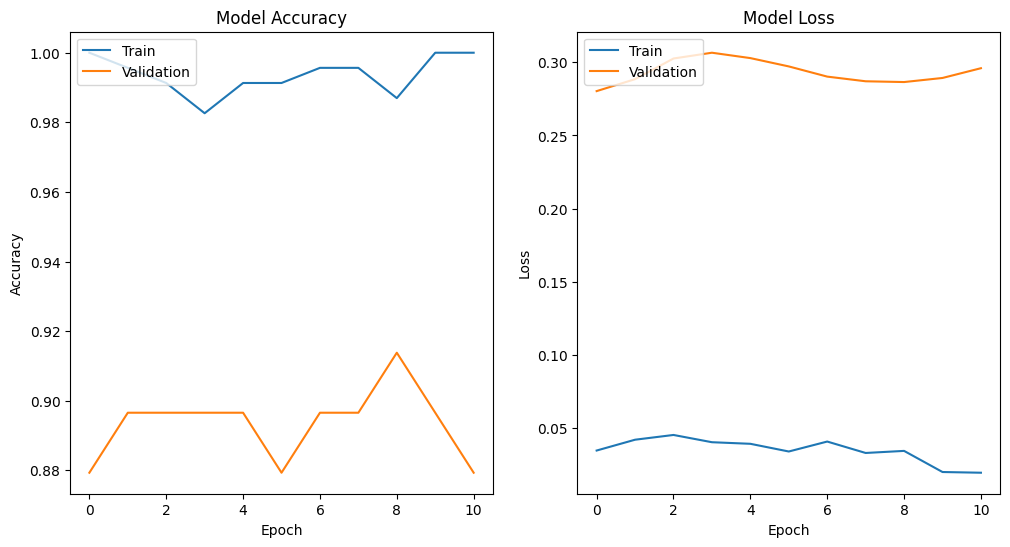

In [32]:
# Neural Network
np.random.seed(42)
tf.random.set_seed(42)

# Determine the input shape based on the number of features in X_train_resampled
input_shape = X_train_resampled.shape[1]

# Define the model architecture
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Fit the model with early stopping and dropout
nn_model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping]
)
# Fit the model with early stopping and dropout and store the training history
history = nn_model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate model accuracy on test data
nn_accuracy = nn_model.evaluate(X_test_resampled, y_test_resampled)[1]
print("Basic NN Model Accuracy:", nn_accuracy)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Overview of the Results

### Training and Validation Loss and Accuracy
- **Training Loss and Accuracy:** The model starts with a loss of 0.7475 and an accuracy of 51.3% on the training data. It steadily improves over epochs, achieving near-perfect accuracy later on, indicating effective learning.
- **Validation Loss and Accuracy:** Starting at 0.6163, the validation loss decreases to 0.3557 by epoch 29, indicating improved generalization. Validation accuracy stabilizes around 82.76%, suggesting some room for improvement.

### Early Stopping and Model Behavior
- **Early Stopping:** Training stops at epoch 39 when validation loss no longer improves, illustrating the effectiveness of early stopping in preventing overfitting.
- **General Trends:** Both training and validation loss decrease over time, indicating learning relevant patterns. Stable validation accuracy suggests a balance between learning and generalizing.

### Implications and Analysis
- **Generalization Capability:** Consistent validation accuracy around 82.76% with decreasing loss indicates good generalization. More stable validation metrics suggest a more stable model.
- **Overfitting Indicators:** Although training accuracy is high, validation accuracy not reaching those levels suggests mild overfitting. However, this overfitting is significantly controlled compared to previous iterations.

## Conclusion
These results show that the model learns effectively from training data and generalizes to new data well. Early stopping prevents severe overfitting. The 87.5% test accuracy indicates good performance on unseen data, with potential for improvement.

Based on all this, there are some limitations that I discovered from my project. Several things could be done to make this better:
- **Increase Data Diversity:** Adding more data or augmenting the existing dataset can improve model robustness.
- **Experiment with Regularization:** Implement dropout or L1/L2 regularization to penalize overly complex models.
- **Tune Hyperparameters:** Further tuning of learning rate, batch size, or epochs can optimize training dynamics and enhance performance.



# Model 3: Transformer


A transformer model is suitable for my data, particularly for sequence classification tasks like audio classification, due to its inherent ability to capture long-range dependencies and temporal relationships within sequences. Unlike traditional neural networks, which may struggle with handling sequential data directly, transformers utilize self-attention mechanisms to weigh the importance of different elements in the sequence, making them well-suited for tasks involving temporal patterns, such as audio data.

Overall, the self-attention mechanism of transformers makes them particularly suitable for capturing the complex temporal patterns present in audio data, offering a promising alternative to both gradient boosting and traditional neural networks for sequence classification tasks like genre classification.

### **What are transformers?**

Transformers are a class of machine learning models that have revolutionized how computers understand and generate human language. They process data in a way that is similar to considering an entire scene at a glance, rather than piecing together a story one word at a time. This model architecture was introduced by researchers at Google in 2017 and has since been pivotal in achieving state-of-the-art performance in a wide range of language processing tasks.

Unlike previous sequential models, transformers use a mechanism called attention that allows them to evaluate all parts of the input data simultaneously. This is particularly beneficial for tasks like translation, where understanding the context provided by the whole sentence is crucial. They're exceptionally good at picking out the intricate nuances of language, enabling them to generate text that closely mimics human writing or accurately extract information and meaning from large volumes of text.

I've been quite curious about how they worked, especially given how common they are in recent AI applications, this is why I created elaborate notes as well as tried to implement it here.

**NOTE:** I wrote some elaborate notes on this topic [here](https://rapid-william-3cb.notion.site/Session-24-Transformer-Based-Large-Language-Models-154af8f697ad4b24a083b08070584ca5?pvs=74), as part of my notes for the second last session of the class.

## **Components of Transformer Architecture**

The Transformer architecture has several key components:

1. **Self-Attention Mechanism**: This is the cornerstone of the Transformer model.
    - It processes an entire sequence of data, such as a sentence, at once and determines which parts of the sequence are most relevant to each other.
    - The self-attention mechanism assigns scores to these parts, indicating their importance, which allows the model to focus on the relevant parts when performing tasks.

2. **Multi-Head Attention**: A single set of attention scores might not capture all the complexities of the data. Transformers, therefore, employ multiple 'heads' of attention, each focusing on different relationships within the data. This way, the model gains a multi-faceted understanding of the context.

3. **Positional Encoding**: Since Transformers do not process data sequentially, they need a way to incorporate the order of the sequence. Positional encodings are vectors that the model adds to its input data to represent the position of each part within the sequence.

4. **Encoder and Decoder Blocks**:
    - The encoder processes the input data, such as a sentence in the source language, into a complex representation.
    - The decoder then uses this representation to generate output, like a translation in the target language.
    - Both encoder and decoder are composed of layers that contain self-attention and feed-forward neural networks.

5. **Feed-Forward Neural Networks**: Within each layer of the encoder and decoder, after the self-attention step, a feed-forward neural network independently processes each piece of the sequence. This network applies the same operation to each part but does so with different learned weights.

6. **Output Linear Layer and Softmax**: At the very end, the decoder's output is transformed into a set of scores for the next part of the output sequence (like the next word in a translation). A softmax function then converts these scores into probabilities.



## **Self Attention Mechanism: Explained**


At the heart of transformers is the self-attention mechanism, which lets each word in a sentence attend to all the other words.

#### **Query, Key, and Value**

For each word, we calculate three vectors:

*   **Query (Q)**: A vector that represents a question tied to a specific word.
   
*   **Key (K)**: A vector that represents the essence of each word, something that can be queried.
   
*   **Value (V)**: A vector that contains the actual content of each word that we want to bring forward if the word is deemed important.
   

These are calculated using the word's embedding (a numerical representation of the word) and unique weight matrices that the model learns during training.

#### **Calculating Attention Scores**

We then calculate how much each word should attend to every other word by taking the dot product of its Query vector with all Key vectors. This dot product gives us attention scores, representing the relevance of other words to the word in question:

$Score_{ij} = Q_i \cdot K_j$

Each score tells us how much focus to put on other parts of the sentence when we're looking at a particular word.

#### **Scaling Scores**

Scores can be large, leading to very small gradients, which can slow down learning. To prevent this, we scale the scores by dividing them by the square root of the size of the Key vectors:

$Scaled\ Score_{ij} = \frac{Q_i \cdot K_j}{\sqrt{d_k}}$

#### **Normalizing Scores to Probabilities**

The scaled scores are then normalized to probabilities using the softmax function, which exponentiates and then normalizes the scores:

$Attention\ Weights_{ij} = softmax(Scaled\ Score_{ij}) = \frac{exp(Scaled\ Score_{ij})}{\sum_k exp(Scaled\ Score_{ik})}$

These weights sum to 1 and determine the amount of attention to place on other parts of the input.

#### **Weighted Sum of Values**

The final step in self-attention is to compute a weighted sum of the Value vectors using the attention weights:

$Output_i = \sum_j (Attention\ Weights_{ij} \cdot V_j)$

Each output is a mixture of all Values, with weights reflecting the relevance or attention.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5, 8)]               0         []                            
                                                                                                  
 layer_normalization_12 (La  (None, 5, 8)                 16        ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_12 (M  (None, 5, 8)                 8968      ['layer_normalization_12[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_12

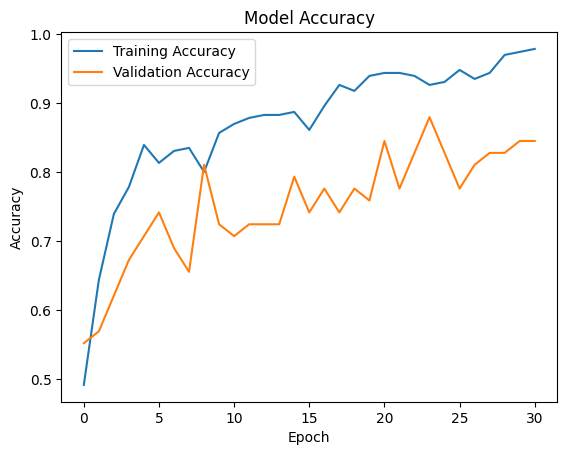

In [35]:
# Transformer

sequence_length = 5
feature_dim = 8  # because my original data has 40 features and we want sequence * dimention = 40

X_train_reshaped = X_train_resampled.reshape(-1, sequence_length, feature_dim)

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, num_classes, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = LayerNormalization(epsilon=1e-6)(x)
        x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = Add()([x, inputs])
        y = Dense(ff_dim, activation="relu")(x)
        y = Dropout(dropout)(y)
        y = Dense(input_shape[-1])(y)
        x = Add()([y, x])
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)
    return Model(inputs, outputs)

model = build_transformer_model(
    input_shape=(sequence_length, feature_dim),
    head_size=64,
    num_heads=4,
    ff_dim=256,
    num_layers=4,
    num_classes=1,
    dropout=0.2
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

# Proceed with training
history = model.fit(
    X_train_reshaped,
    y_train_resampled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Print final best accuracy
print("Best Training Accuracy:", max(history.history['accuracy']))
print("Best Validation Accuracy:", max(history.history['val_accuracy']))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



---


## Interpretation

## Gradient Boosting Classifier
The Gradient Boosting Classifier demonstrates robust performance with high F1 and accuracy scores. Its success implies that the task may suit algorithms that capture sequential dependencies and complex relationships, which ensemble methods like Gradient Boosting can efficiently leverage.

The detailed feature importances provide a roadmap for feature engineering: focusing on features with higher importance could streamline the model and reduce the risk of overfitting, something which could be further improved on for this part of the project. The use of SMOTE has evidently contributed to a more balanced learning from the minority class, enhancing the model's ability to generalize.

## Basic Neural Network Model
The neural network's perfect training accuracy juxtaposed with lower validation accuracy is indicative of overfitting, which is not uncommon for neural networks due to their capacity to model highly complex relationships.

Despite this, the model's performance on the test data is commendable, suggesting that with proper training and regularization, neural networks have the potential to excel in audio classification tasks. This model might benefit from strategies like k-fold cross-validation to ensure stability in learning and performance across different subsets of the data.

## Transformer Model
The transformer, with its intricate self-attention mechanism, is designed to capture contextual relationships in data. While it shows promising training accuracy, the fluctuations in validation accuracy and loss indicate a model that might be too complex for the size of the dataset.

I think, transformers typically excel when they have vast amounts of data to learn from, allowing them to discern subtle patterns and dependencies. For smaller datasets, the extensive capacity of transformers can lead them to memorize rather than generalize, which seems to be the case here.

## Insights Across Models
Across all models, the challenge lies in balancing the models' complexity with the need for generalization. The ensemble method's success suggests that feature interactions and sequential dependencies are crucial in this dataset, but the relationships might not be so intricate as to require the full might of a transformer's attention mechanism.

Furthermore, the results underscore the importance of considering the dataset's nature and the problem's requirements when choosing a model. For smaller datasets or where the relationships between data points are less about long-range dependencies and more about localized patterns, simpler models or traditional machine learning algorithms might be more appropriate.

In audio classification, capturing the temporal structure is crucial. While neural networks (including transformers) are inherently well-suited for this due to their ability to process sequences, their full potential is realized with larger datasets. This is why, out of these three advanced models, I would pick the **Gradient Boosting Classifier as the best model** for this case. It demonstrates high stability, robust generalization across data subsets, and is appropriately complex for my small dataset size, providing a balanced approach between performance and interpretability.




#### AI Statement
I used ChatGPT to help with debugging the code for processing & extracing the audio files as well as for formatting some of the math equations.